## Using pre-trained NN

In [1]:
!conda install -y nomkl > tmp.log

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [7]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2017-06-01 13:45:57--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.49.27
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.49.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: ‘vgg16.pkl’

vgg16.pkl           100%[===================>] 527.82M  1.14MB/s    in 9m 31s  

2017-06-01 13:55:30 (946 KB/s) - ‘vgg16.pkl’ saved [553459517/553459517]



In [24]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [25]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [47]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:, :, ::-1]
    #for i in range(3):
    #    img[:,:, i] -= MEAN_VALUES[i]
    img = img - MEAN_VALUES    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    img += MEAN_VALUES
    #for i in range(3):
    #    img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [48]:
net = build_model()

In [49]:
print(type(net['prob']))

<class 'lasagne.layers.special.NonlinearityLayer'>


In [50]:
import pickle
with open('vgg16.pkl', 'rb') as f:
    weights = pickle.load(f, encoding='latin1')
    
all_params = weights['param values']
lasagne.layers.set_all_param_values(net['prob'], all_params)

In [51]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)
prob = theano.function([input_image], output, allow_input_downcast=True)
features = lasagne.layers.get_output(net['pool5'], input_image)
get_features = theano.function([input_image], features, allow_input_downcast=True)

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

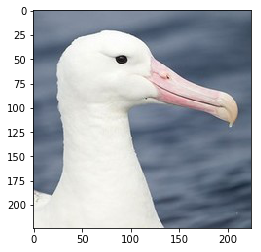

top-5 classes are:
0.999263	albatross
0.000727	goose
0.000006	drake
0.000002	red-breasted merganser
0.000001	oystercatcher


In [52]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

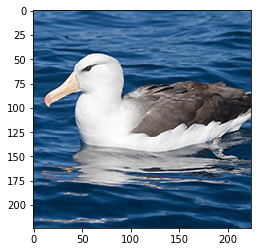

top-5 classes are:
0.999985	albatross
0.000012	oystercatcher
0.000002	killer whale
0.000001	goose
0.000000	drake


In [54]:
img = imread('sample_images/albatross1.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [46]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2017-06-01 14:07:25--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/vf5hMURKLoqh8qCniaD0I7NzlqAvBtsCCcgM58PCv47apocCXpIjO1qiHgFCIB77/file?dl=1 [following]
--2017-06-01 14:07:26--  https://dl.dropboxusercontent.com/content_link/vf5hMURKLoqh8qCniaD0I7NzlqAvBtsCCcgM58PCv47apocCXpIjO1qiHgFCIB77/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.64.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.64.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 543.16M  1.51MB/s    in 2m 7s   

2017-06-01 14:09:35 (4.26 MB/s) - ‘data.zip’ saved

  inflating: train/cat.10172.jpg     
  inflating: train/cat.10173.jpg     
  inflating: train/cat.10174.jpg     
  inflating: train/cat.10175.jpg     
  inflating: train/cat.10176.jpg     
  inflating: train/cat.10177.jpg     
  inflating: train/cat.10178.jpg     
  inflating: train/cat.10179.jpg     
  inflating: train/cat.1018.jpg      
  inflating: train/cat.10180.jpg     
  inflating: train/cat.10181.jpg     
  inflating: train/cat.10182.jpg     
  inflating: train/cat.10183.jpg     
  inflating: train/cat.10184.jpg     
  inflating: train/cat.10185.jpg     
  inflating: train/cat.10186.jpg     
  inflating: train/cat.10187.jpg     
  inflating: train/cat.10188.jpg     
  inflating: train/cat.10189.jpg     
  inflating: train/cat.1019.jpg      
  inflating: train/cat.10190.jpg     
  inflating: train/cat.10191.jpg     
  inflating: train/cat.10192.jpg     
  inflating: train/cat.10193.jpg     
  inflating: train/cat.10194.jpg     
  inflating: train/cat.10195.jpg     
  inflating:

  inflating: train/cat.10553.jpg     
  inflating: train/cat.10554.jpg     
  inflating: train/cat.10555.jpg     
  inflating: train/cat.10556.jpg     
  inflating: train/cat.10557.jpg     
  inflating: train/cat.10558.jpg     
  inflating: train/cat.10559.jpg     
  inflating: train/cat.1056.jpg      
  inflating: train/cat.10560.jpg     
  inflating: train/cat.10561.jpg     
  inflating: train/cat.10562.jpg     
  inflating: train/cat.10563.jpg     
  inflating: train/cat.10564.jpg     
  inflating: train/cat.10565.jpg     
  inflating: train/cat.10566.jpg     
  inflating: train/cat.10567.jpg     
  inflating: train/cat.10568.jpg     
  inflating: train/cat.10569.jpg     
  inflating: train/cat.1057.jpg      
  inflating: train/cat.10570.jpg     
  inflating: train/cat.10571.jpg     
  inflating: train/cat.10572.jpg     
  inflating: train/cat.10573.jpg     
  inflating: train/cat.10574.jpg     
  inflating: train/cat.10575.jpg     
  inflating: train/cat.10576.jpg     
  inflating:

  inflating: train/cat.10770.jpg     
  inflating: train/cat.10771.jpg     
  inflating: train/cat.10772.jpg     
  inflating: train/cat.10773.jpg     
  inflating: train/cat.10774.jpg     
  inflating: train/cat.10775.jpg     
  inflating: train/cat.10776.jpg     
  inflating: train/cat.10777.jpg     
  inflating: train/cat.10778.jpg     
  inflating: train/cat.10779.jpg     
  inflating: train/cat.1078.jpg      
  inflating: train/cat.10780.jpg     
  inflating: train/cat.10781.jpg     
  inflating: train/cat.10782.jpg     
  inflating: train/cat.10783.jpg     
  inflating: train/cat.10784.jpg     
  inflating: train/cat.10785.jpg     
  inflating: train/cat.10786.jpg     
  inflating: train/cat.10787.jpg     
  inflating: train/cat.10788.jpg     
  inflating: train/cat.10789.jpg     
  inflating: train/cat.1079.jpg      
  inflating: train/cat.10790.jpg     
  inflating: train/cat.10791.jpg     
  inflating: train/cat.10792.jpg     
  inflating: train/cat.10793.jpg     
  inflating:

  inflating: train/cat.10965.jpg     
  inflating: train/cat.10966.jpg     
  inflating: train/cat.10967.jpg     
  inflating: train/cat.10968.jpg     
  inflating: train/cat.10969.jpg     
  inflating: train/cat.1097.jpg      
  inflating: train/cat.10970.jpg     
  inflating: train/cat.10971.jpg     
  inflating: train/cat.10972.jpg     
  inflating: train/cat.10973.jpg     
  inflating: train/cat.10974.jpg     
  inflating: train/cat.10975.jpg     
  inflating: train/cat.10976.jpg     
  inflating: train/cat.10977.jpg     
  inflating: train/cat.10978.jpg     
  inflating: train/cat.10979.jpg     
  inflating: train/cat.1098.jpg      
  inflating: train/cat.10980.jpg     
  inflating: train/cat.10981.jpg     
  inflating: train/cat.10982.jpg     
  inflating: train/cat.10983.jpg     
  inflating: train/cat.10984.jpg     
  inflating: train/cat.10985.jpg     
  inflating: train/cat.10986.jpg     
  inflating: train/cat.10987.jpg     
  inflating: train/cat.10988.jpg     
  inflating:

  inflating: train/cat.11173.jpg     
  inflating: train/cat.11174.jpg     
  inflating: train/cat.11175.jpg     
  inflating: train/cat.11176.jpg     
  inflating: train/cat.11177.jpg     
  inflating: train/cat.11178.jpg     
  inflating: train/cat.11179.jpg     
  inflating: train/cat.1118.jpg      
  inflating: train/cat.11180.jpg     
  inflating: train/cat.11181.jpg     
  inflating: train/cat.11182.jpg     
  inflating: train/cat.11183.jpg     
  inflating: train/cat.11184.jpg     
  inflating: train/cat.11185.jpg     
  inflating: train/cat.11186.jpg     
  inflating: train/cat.11187.jpg     
  inflating: train/cat.11188.jpg     
  inflating: train/cat.11189.jpg     
  inflating: train/cat.1119.jpg      
  inflating: train/cat.11190.jpg     
  inflating: train/cat.11191.jpg     
  inflating: train/cat.11192.jpg     
  inflating: train/cat.11193.jpg     
  inflating: train/cat.11194.jpg     
  inflating: train/cat.11195.jpg     
  inflating: train/cat.11196.jpg     
  inflating:

  inflating: train/cat.11381.jpg     
  inflating: train/cat.11382.jpg     
  inflating: train/cat.11383.jpg     
  inflating: train/cat.11384.jpg     
  inflating: train/cat.11385.jpg     
  inflating: train/cat.11386.jpg     
  inflating: train/cat.11387.jpg     
  inflating: train/cat.11388.jpg     
  inflating: train/cat.11389.jpg     
  inflating: train/cat.1139.jpg      
  inflating: train/cat.11390.jpg     
  inflating: train/cat.11391.jpg     
  inflating: train/cat.11392.jpg     
  inflating: train/cat.11393.jpg     
  inflating: train/cat.11394.jpg     
  inflating: train/cat.11395.jpg     
  inflating: train/cat.11396.jpg     
  inflating: train/cat.11397.jpg     
  inflating: train/cat.11398.jpg     
  inflating: train/cat.11399.jpg     
  inflating: train/cat.114.jpg       
  inflating: train/cat.1140.jpg      
  inflating: train/cat.11400.jpg     
  inflating: train/cat.11401.jpg     
  inflating: train/cat.11402.jpg     
  inflating: train/cat.11403.jpg     
  inflating:

  inflating: train/cat.11590.jpg     
  inflating: train/cat.11591.jpg     
  inflating: train/cat.11592.jpg     
  inflating: train/cat.11593.jpg     
  inflating: train/cat.11594.jpg     
  inflating: train/cat.11595.jpg     
  inflating: train/cat.11596.jpg     
  inflating: train/cat.11597.jpg     
  inflating: train/cat.11598.jpg     
  inflating: train/cat.11599.jpg     
  inflating: train/cat.116.jpg       
  inflating: train/cat.1160.jpg      
  inflating: train/cat.11600.jpg     
  inflating: train/cat.11601.jpg     
  inflating: train/cat.11602.jpg     
  inflating: train/cat.11603.jpg     
  inflating: train/cat.11604.jpg     
  inflating: train/cat.11605.jpg     
  inflating: train/cat.11606.jpg     
  inflating: train/cat.11607.jpg     
  inflating: train/cat.11608.jpg     
  inflating: train/cat.11609.jpg     
  inflating: train/cat.1161.jpg      
  inflating: train/cat.11610.jpg     
  inflating: train/cat.11611.jpg     
  inflating: train/cat.11612.jpg     
  inflating:

  inflating: train/cat.11805.jpg     
  inflating: train/cat.11806.jpg     
  inflating: train/cat.11807.jpg     
  inflating: train/cat.11808.jpg     
  inflating: train/cat.11809.jpg     
  inflating: train/cat.1181.jpg      
  inflating: train/cat.11810.jpg     
  inflating: train/cat.11811.jpg     
  inflating: train/cat.11812.jpg     
  inflating: train/cat.11813.jpg     
  inflating: train/cat.11814.jpg     
  inflating: train/cat.11815.jpg     
  inflating: train/cat.11816.jpg     
  inflating: train/cat.11817.jpg     
  inflating: train/cat.11818.jpg     
  inflating: train/cat.11819.jpg     
  inflating: train/cat.1182.jpg      
  inflating: train/cat.11820.jpg     
  inflating: train/cat.11821.jpg     
  inflating: train/cat.11822.jpg     
  inflating: train/cat.11823.jpg     
  inflating: train/cat.11824.jpg     
  inflating: train/cat.11825.jpg     
  inflating: train/cat.11826.jpg     
  inflating: train/cat.11827.jpg     
  inflating: train/cat.11828.jpg     
  inflating:

  inflating: train/cat.12005.jpg     
  inflating: train/cat.12006.jpg     
  inflating: train/cat.12007.jpg     
  inflating: train/cat.12008.jpg     
  inflating: train/cat.12009.jpg     
  inflating: train/cat.1201.jpg      
  inflating: train/cat.12010.jpg     
  inflating: train/cat.12011.jpg     
  inflating: train/cat.12012.jpg     
  inflating: train/cat.12013.jpg     
  inflating: train/cat.12014.jpg     
  inflating: train/cat.12015.jpg     
  inflating: train/cat.12016.jpg     
  inflating: train/cat.12017.jpg     
  inflating: train/cat.12018.jpg     
  inflating: train/cat.12019.jpg     
  inflating: train/cat.1202.jpg      
  inflating: train/cat.12020.jpg     
  inflating: train/cat.12021.jpg     
  inflating: train/cat.12022.jpg     
  inflating: train/cat.12023.jpg     
  inflating: train/cat.12024.jpg     
  inflating: train/cat.12025.jpg     
  inflating: train/cat.12026.jpg     
  inflating: train/cat.12027.jpg     
  inflating: train/cat.12028.jpg     
  inflating:

  inflating: train/cat.12218.jpg     
  inflating: train/cat.12219.jpg     
  inflating: train/cat.1222.jpg      
  inflating: train/cat.12220.jpg     
  inflating: train/cat.12221.jpg     
  inflating: train/cat.12222.jpg     
  inflating: train/cat.12223.jpg     
  inflating: train/cat.12224.jpg     
  inflating: train/cat.12225.jpg     
  inflating: train/cat.12226.jpg     
  inflating: train/cat.12227.jpg     
  inflating: train/cat.12228.jpg     
  inflating: train/cat.12229.jpg     
  inflating: train/cat.1223.jpg      
  inflating: train/cat.12230.jpg     
  inflating: train/cat.12231.jpg     
  inflating: train/cat.12232.jpg     
  inflating: train/cat.12233.jpg     
  inflating: train/cat.12234.jpg     
  inflating: train/cat.12235.jpg     
  inflating: train/cat.12236.jpg     
  inflating: train/cat.12237.jpg     
  inflating: train/cat.12238.jpg     
  inflating: train/cat.12239.jpg     
  inflating: train/cat.1224.jpg      
  inflating: train/cat.12240.jpg     
  inflating:

  inflating: train/cat.12440.jpg     
  inflating: train/cat.12441.jpg     
  inflating: train/cat.12442.jpg     
  inflating: train/cat.12443.jpg     
  inflating: train/cat.12444.jpg     
  inflating: train/cat.12445.jpg     
  inflating: train/cat.12446.jpg     
  inflating: train/cat.12447.jpg     
  inflating: train/cat.12448.jpg     
  inflating: train/cat.12449.jpg     
  inflating: train/cat.1245.jpg      
  inflating: train/cat.12450.jpg     
  inflating: train/cat.12451.jpg     
  inflating: train/cat.12452.jpg     
  inflating: train/cat.12453.jpg     
  inflating: train/cat.12454.jpg     
  inflating: train/cat.12455.jpg     
  inflating: train/cat.12456.jpg     
  inflating: train/cat.12457.jpg     
  inflating: train/cat.12458.jpg     
  inflating: train/cat.12459.jpg     
  inflating: train/cat.1246.jpg      
  inflating: train/cat.12460.jpg     
  inflating: train/cat.12461.jpg     
  inflating: train/cat.12462.jpg     
  inflating: train/cat.12463.jpg     
  inflating:

  inflating: train/cat.139.jpg       
  inflating: train/cat.1390.jpg      
  inflating: train/cat.1391.jpg      
  inflating: train/cat.1392.jpg      
  inflating: train/cat.1393.jpg      
  inflating: train/cat.1394.jpg      
  inflating: train/cat.1395.jpg      
  inflating: train/cat.1396.jpg      
  inflating: train/cat.1397.jpg      
  inflating: train/cat.1398.jpg      
  inflating: train/cat.1399.jpg      
  inflating: train/cat.14.jpg        
  inflating: train/cat.140.jpg       
  inflating: train/cat.1400.jpg      
  inflating: train/cat.1401.jpg      
  inflating: train/cat.1402.jpg      
  inflating: train/cat.1403.jpg      
  inflating: train/cat.1404.jpg      
  inflating: train/cat.1405.jpg      
  inflating: train/cat.1406.jpg      
  inflating: train/cat.1407.jpg      
  inflating: train/cat.1408.jpg      
  inflating: train/cat.1409.jpg      
  inflating: train/cat.141.jpg       
  inflating: train/cat.1410.jpg      
  inflating: train/cat.1411.jpg      
  inflating:

  inflating: train/cat.1602.jpg      
  inflating: train/cat.1603.jpg      
  inflating: train/cat.1604.jpg      
  inflating: train/cat.1605.jpg      
  inflating: train/cat.1606.jpg      
  inflating: train/cat.1607.jpg      
  inflating: train/cat.1608.jpg      
  inflating: train/cat.1609.jpg      
  inflating: train/cat.161.jpg       
  inflating: train/cat.1610.jpg      
  inflating: train/cat.1611.jpg      
  inflating: train/cat.1612.jpg      
  inflating: train/cat.1613.jpg      
  inflating: train/cat.1614.jpg      
  inflating: train/cat.1615.jpg      
  inflating: train/cat.1616.jpg      
  inflating: train/cat.1617.jpg      
  inflating: train/cat.1618.jpg      
  inflating: train/cat.1619.jpg      
  inflating: train/cat.162.jpg       
  inflating: train/cat.1620.jpg      
  inflating: train/cat.1621.jpg      
  inflating: train/cat.1622.jpg      
  inflating: train/cat.1623.jpg      
  inflating: train/cat.1624.jpg      
  inflating: train/cat.1625.jpg      
  inflating:

  inflating: train/cat.1815.jpg      
  inflating: train/cat.1816.jpg      
  inflating: train/cat.1817.jpg      
  inflating: train/cat.1818.jpg      
  inflating: train/cat.1819.jpg      
  inflating: train/cat.182.jpg       
  inflating: train/cat.1820.jpg      
  inflating: train/cat.1821.jpg      
  inflating: train/cat.1822.jpg      
  inflating: train/cat.1823.jpg      
  inflating: train/cat.1824.jpg      
  inflating: train/cat.1825.jpg      
  inflating: train/cat.1826.jpg      
  inflating: train/cat.1827.jpg      
  inflating: train/cat.1828.jpg      
  inflating: train/cat.1829.jpg      
  inflating: train/cat.183.jpg       
  inflating: train/cat.1830.jpg      
  inflating: train/cat.1831.jpg      
  inflating: train/cat.1832.jpg      
  inflating: train/cat.1833.jpg      
  inflating: train/cat.1834.jpg      
  inflating: train/cat.1835.jpg      
  inflating: train/cat.1836.jpg      
  inflating: train/cat.1837.jpg      
  inflating: train/cat.1838.jpg      
  inflating:

  inflating: train/cat.2020.jpg      
  inflating: train/cat.2021.jpg      
  inflating: train/cat.2022.jpg      
  inflating: train/cat.2023.jpg      
  inflating: train/cat.2024.jpg      
  inflating: train/cat.2025.jpg      
  inflating: train/cat.2026.jpg      
  inflating: train/cat.2027.jpg      
  inflating: train/cat.2028.jpg      
  inflating: train/cat.2029.jpg      
  inflating: train/cat.203.jpg       
  inflating: train/cat.2030.jpg      
  inflating: train/cat.2031.jpg      
  inflating: train/cat.2032.jpg      
  inflating: train/cat.2033.jpg      
  inflating: train/cat.2034.jpg      
  inflating: train/cat.2035.jpg      
  inflating: train/cat.2036.jpg      
  inflating: train/cat.2037.jpg      
  inflating: train/cat.2038.jpg      
  inflating: train/cat.2039.jpg      
  inflating: train/cat.204.jpg       
  inflating: train/cat.2040.jpg      
  inflating: train/cat.2041.jpg      
  inflating: train/cat.2042.jpg      
  inflating: train/cat.2043.jpg      
  inflating:

  inflating: train/cat.2244.jpg      
  inflating: train/cat.2245.jpg      
  inflating: train/cat.2246.jpg      
  inflating: train/cat.2247.jpg      
  inflating: train/cat.2248.jpg      
  inflating: train/cat.2249.jpg      
  inflating: train/cat.225.jpg       
  inflating: train/cat.2250.jpg      
  inflating: train/cat.2251.jpg      
  inflating: train/cat.2252.jpg      
  inflating: train/cat.2253.jpg      
  inflating: train/cat.2254.jpg      
  inflating: train/cat.2255.jpg      
  inflating: train/cat.2256.jpg      
  inflating: train/cat.2257.jpg      
  inflating: train/cat.2258.jpg      
  inflating: train/cat.2259.jpg      
  inflating: train/cat.226.jpg       
  inflating: train/cat.2260.jpg      
  inflating: train/cat.2261.jpg      
  inflating: train/cat.2262.jpg      
  inflating: train/cat.2263.jpg      
  inflating: train/cat.2264.jpg      
  inflating: train/cat.2265.jpg      
  inflating: train/cat.2266.jpg      
  inflating: train/cat.2267.jpg      
  inflating:

  inflating: train/cat.2451.jpg      
  inflating: train/cat.2452.jpg      
  inflating: train/cat.2453.jpg      
  inflating: train/cat.2454.jpg      
  inflating: train/cat.2455.jpg      
  inflating: train/cat.2456.jpg      
  inflating: train/cat.2457.jpg      
  inflating: train/cat.2458.jpg      
  inflating: train/cat.2459.jpg      
  inflating: train/cat.246.jpg       
  inflating: train/cat.2460.jpg      
  inflating: train/cat.2461.jpg      
  inflating: train/cat.2462.jpg      
  inflating: train/cat.2463.jpg      
  inflating: train/cat.2464.jpg      
  inflating: train/cat.2465.jpg      
  inflating: train/cat.2466.jpg      
  inflating: train/cat.2467.jpg      
  inflating: train/cat.2468.jpg      
  inflating: train/cat.2469.jpg      
  inflating: train/cat.247.jpg       
  inflating: train/cat.2470.jpg      
  inflating: train/cat.2471.jpg      
  inflating: train/cat.2472.jpg      
  inflating: train/cat.2473.jpg      
  inflating: train/cat.2474.jpg      
  inflating:

  inflating: train/cat.266.jpg       
  inflating: train/cat.2660.jpg      
  inflating: train/cat.2661.jpg      
  inflating: train/cat.2662.jpg      
  inflating: train/cat.2663.jpg      
  inflating: train/cat.2664.jpg      
  inflating: train/cat.2665.jpg      
  inflating: train/cat.2666.jpg      
  inflating: train/cat.2667.jpg      
  inflating: train/cat.2668.jpg      
  inflating: train/cat.2669.jpg      
  inflating: train/cat.267.jpg       
  inflating: train/cat.2670.jpg      
  inflating: train/cat.2671.jpg      
  inflating: train/cat.2672.jpg      
  inflating: train/cat.2673.jpg      
  inflating: train/cat.2674.jpg      
  inflating: train/cat.2675.jpg      
  inflating: train/cat.2676.jpg      
  inflating: train/cat.2677.jpg      
  inflating: train/cat.2678.jpg      
  inflating: train/cat.2679.jpg      
  inflating: train/cat.268.jpg       
  inflating: train/cat.2680.jpg      
  inflating: train/cat.2681.jpg      
  inflating: train/cat.2682.jpg      
  inflating:

  inflating: train/cat.2864.jpg      
  inflating: train/cat.2865.jpg      
  inflating: train/cat.2866.jpg      
  inflating: train/cat.2867.jpg      
  inflating: train/cat.2868.jpg      
  inflating: train/cat.2869.jpg      
  inflating: train/cat.287.jpg       
  inflating: train/cat.2870.jpg      
  inflating: train/cat.2871.jpg      
  inflating: train/cat.2872.jpg      
  inflating: train/cat.2873.jpg      
  inflating: train/cat.2874.jpg      
  inflating: train/cat.2875.jpg      
  inflating: train/cat.2876.jpg      
  inflating: train/cat.2877.jpg      
  inflating: train/cat.2878.jpg      
  inflating: train/cat.2879.jpg      
  inflating: train/cat.288.jpg       
  inflating: train/cat.2880.jpg      
  inflating: train/cat.2881.jpg      
  inflating: train/cat.2882.jpg      
  inflating: train/cat.2883.jpg      
  inflating: train/cat.2884.jpg      
  inflating: train/cat.2885.jpg      
  inflating: train/cat.2886.jpg      
  inflating: train/cat.2887.jpg      
  inflating:

  inflating: train/cat.3059.jpg      
  inflating: train/cat.306.jpg       
  inflating: train/cat.3060.jpg      
  inflating: train/cat.3061.jpg      
  inflating: train/cat.3062.jpg      
  inflating: train/cat.3063.jpg      
  inflating: train/cat.3064.jpg      
  inflating: train/cat.3065.jpg      
  inflating: train/cat.3066.jpg      
  inflating: train/cat.3067.jpg      
  inflating: train/cat.3068.jpg      
  inflating: train/cat.3069.jpg      
  inflating: train/cat.307.jpg       
  inflating: train/cat.3070.jpg      
  inflating: train/cat.3071.jpg      
  inflating: train/cat.3072.jpg      
  inflating: train/cat.3073.jpg      
  inflating: train/cat.3074.jpg      
  inflating: train/cat.3075.jpg      
  inflating: train/cat.3076.jpg      
  inflating: train/cat.3077.jpg      
  inflating: train/cat.3078.jpg      
  inflating: train/cat.3079.jpg      
  inflating: train/cat.308.jpg       
  inflating: train/cat.3080.jpg      
  inflating: train/cat.3081.jpg      
  inflating:

  inflating: train/cat.3262.jpg      
  inflating: train/cat.3263.jpg      
  inflating: train/cat.3264.jpg      
  inflating: train/cat.3265.jpg      
  inflating: train/cat.3266.jpg      
  inflating: train/cat.3267.jpg      
  inflating: train/cat.3268.jpg      
  inflating: train/cat.3269.jpg      
  inflating: train/cat.327.jpg       
  inflating: train/cat.3270.jpg      
  inflating: train/cat.3271.jpg      
  inflating: train/cat.3272.jpg      
  inflating: train/cat.3273.jpg      
  inflating: train/cat.3274.jpg      
  inflating: train/cat.3275.jpg      
  inflating: train/cat.3276.jpg      
  inflating: train/cat.3277.jpg      
  inflating: train/cat.3278.jpg      
  inflating: train/cat.3279.jpg      
  inflating: train/cat.328.jpg       
  inflating: train/cat.3280.jpg      
  inflating: train/cat.3281.jpg      
  inflating: train/cat.3282.jpg      
  inflating: train/cat.3283.jpg      
  inflating: train/cat.3284.jpg      
  inflating: train/cat.3285.jpg      
  inflating:

  inflating: train/cat.3467.jpg      
  inflating: train/cat.3468.jpg      
  inflating: train/cat.3469.jpg      
  inflating: train/cat.347.jpg       
  inflating: train/cat.3470.jpg      
  inflating: train/cat.3471.jpg      
  inflating: train/cat.3472.jpg      
  inflating: train/cat.3473.jpg      
  inflating: train/cat.3474.jpg      
  inflating: train/cat.3475.jpg      
  inflating: train/cat.3476.jpg      
  inflating: train/cat.3477.jpg      
  inflating: train/cat.3478.jpg      
  inflating: train/cat.3479.jpg      
  inflating: train/cat.348.jpg       
  inflating: train/cat.3480.jpg      
  inflating: train/cat.3481.jpg      
  inflating: train/cat.3482.jpg      
  inflating: train/cat.3483.jpg      
  inflating: train/cat.3484.jpg      
  inflating: train/cat.3485.jpg      
  inflating: train/cat.3486.jpg      
  inflating: train/cat.3487.jpg      
  inflating: train/cat.3488.jpg      
  inflating: train/cat.3489.jpg      
  inflating: train/cat.349.jpg       
  inflating:

  inflating: train/cat.3685.jpg      
  inflating: train/cat.3686.jpg      
  inflating: train/cat.3687.jpg      
  inflating: train/cat.3688.jpg      
  inflating: train/cat.3689.jpg      
  inflating: train/cat.369.jpg       
  inflating: train/cat.3690.jpg      
  inflating: train/cat.3691.jpg      
  inflating: train/cat.3692.jpg      
  inflating: train/cat.3693.jpg      
  inflating: train/cat.3694.jpg      
  inflating: train/cat.3695.jpg      
  inflating: train/cat.3696.jpg      
  inflating: train/cat.3697.jpg      
  inflating: train/cat.3698.jpg      
  inflating: train/cat.3699.jpg      
  inflating: train/cat.37.jpg        
  inflating: train/cat.370.jpg       
  inflating: train/cat.3700.jpg      
  inflating: train/cat.3701.jpg      
  inflating: train/cat.3702.jpg      
  inflating: train/cat.3703.jpg      
  inflating: train/cat.3704.jpg      
  inflating: train/cat.3705.jpg      
  inflating: train/cat.3706.jpg      
  inflating: train/cat.3707.jpg      
  inflating:

  inflating: train/cat.3911.jpg      
  inflating: train/cat.3912.jpg      
  inflating: train/cat.3913.jpg      
  inflating: train/cat.3914.jpg      
  inflating: train/cat.3915.jpg      
  inflating: train/cat.3916.jpg      
  inflating: train/cat.3917.jpg      
  inflating: train/cat.3918.jpg      
  inflating: train/cat.3919.jpg      
  inflating: train/cat.392.jpg       
  inflating: train/cat.3920.jpg      
  inflating: train/cat.3921.jpg      
  inflating: train/cat.3922.jpg      
  inflating: train/cat.3923.jpg      
  inflating: train/cat.3924.jpg      
  inflating: train/cat.3925.jpg      
  inflating: train/cat.3926.jpg      
  inflating: train/cat.3927.jpg      
  inflating: train/cat.3928.jpg      
  inflating: train/cat.3929.jpg      
  inflating: train/cat.393.jpg       
  inflating: train/cat.3930.jpg      
  inflating: train/cat.3931.jpg      
  inflating: train/cat.3932.jpg      
  inflating: train/cat.3933.jpg      
  inflating: train/cat.3934.jpg      
  inflating:

  inflating: train/cat.4124.jpg      
  inflating: train/cat.4125.jpg      
  inflating: train/cat.4126.jpg      
  inflating: train/cat.4127.jpg      
  inflating: train/cat.4128.jpg      
  inflating: train/cat.4129.jpg      
  inflating: train/cat.413.jpg       
  inflating: train/cat.4130.jpg      
  inflating: train/cat.4131.jpg      
  inflating: train/cat.4132.jpg      
  inflating: train/cat.4133.jpg      
  inflating: train/cat.4134.jpg      
  inflating: train/cat.4135.jpg      
  inflating: train/cat.4136.jpg      
  inflating: train/cat.4137.jpg      
  inflating: train/cat.4138.jpg      
  inflating: train/cat.4139.jpg      
  inflating: train/cat.414.jpg       
  inflating: train/cat.4140.jpg      
  inflating: train/cat.4141.jpg      
  inflating: train/cat.4142.jpg      
  inflating: train/cat.4143.jpg      
  inflating: train/cat.4144.jpg      
  inflating: train/cat.4145.jpg      
  inflating: train/cat.4146.jpg      
  inflating: train/cat.4147.jpg      
  inflating:

  inflating: train/cat.4318.jpg      
  inflating: train/cat.4319.jpg      
  inflating: train/cat.432.jpg       
  inflating: train/cat.4320.jpg      
  inflating: train/cat.4321.jpg      
  inflating: train/cat.4322.jpg      
  inflating: train/cat.4323.jpg      
  inflating: train/cat.4324.jpg      
  inflating: train/cat.4325.jpg      
  inflating: train/cat.4326.jpg      
  inflating: train/cat.4327.jpg      
  inflating: train/cat.4328.jpg      
  inflating: train/cat.4329.jpg      
  inflating: train/cat.433.jpg       
  inflating: train/cat.4330.jpg      
  inflating: train/cat.4331.jpg      
  inflating: train/cat.4332.jpg      
  inflating: train/cat.4333.jpg      
  inflating: train/cat.4334.jpg      
  inflating: train/cat.4335.jpg      
  inflating: train/cat.4336.jpg      
  inflating: train/cat.4337.jpg      
  inflating: train/cat.4338.jpg      
  inflating: train/cat.4339.jpg      
  inflating: train/cat.434.jpg       
  inflating: train/cat.4340.jpg      
  inflating:

  inflating: train/cat.4525.jpg      
  inflating: train/cat.4526.jpg      
  inflating: train/cat.4527.jpg      
  inflating: train/cat.4528.jpg      
  inflating: train/cat.4529.jpg      
  inflating: train/cat.453.jpg       
  inflating: train/cat.4530.jpg      
  inflating: train/cat.4531.jpg      
  inflating: train/cat.4532.jpg      
  inflating: train/cat.4533.jpg      
  inflating: train/cat.4534.jpg      
  inflating: train/cat.4535.jpg      
  inflating: train/cat.4536.jpg      
  inflating: train/cat.4537.jpg      
  inflating: train/cat.4538.jpg      
  inflating: train/cat.4539.jpg      
  inflating: train/cat.454.jpg       
  inflating: train/cat.4540.jpg      
  inflating: train/cat.4541.jpg      
  inflating: train/cat.4542.jpg      
  inflating: train/cat.4543.jpg      
  inflating: train/cat.4544.jpg      
  inflating: train/cat.4545.jpg      
  inflating: train/cat.4546.jpg      
  inflating: train/cat.4547.jpg      
  inflating: train/cat.4548.jpg      
  inflating:

  inflating: train/cat.4769.jpg      
  inflating: train/cat.477.jpg       
  inflating: train/cat.4770.jpg      
  inflating: train/cat.4771.jpg      
  inflating: train/cat.4772.jpg      
  inflating: train/cat.4773.jpg      
  inflating: train/cat.4774.jpg      
  inflating: train/cat.4775.jpg      
  inflating: train/cat.4776.jpg      
  inflating: train/cat.4777.jpg      
  inflating: train/cat.4778.jpg      
  inflating: train/cat.4779.jpg      
  inflating: train/cat.478.jpg       
  inflating: train/cat.4780.jpg      
  inflating: train/cat.4781.jpg      
  inflating: train/cat.4782.jpg      
  inflating: train/cat.4783.jpg      
  inflating: train/cat.4784.jpg      
  inflating: train/cat.4785.jpg      
  inflating: train/cat.4786.jpg      
  inflating: train/cat.4787.jpg      
  inflating: train/cat.4788.jpg      
  inflating: train/cat.4789.jpg      
  inflating: train/cat.479.jpg       
  inflating: train/cat.4790.jpg      
  inflating: train/cat.4791.jpg      
  inflating:

  inflating: train/cat.5014.jpg      
  inflating: train/cat.5015.jpg      
  inflating: train/cat.5016.jpg      
  inflating: train/cat.5017.jpg      
  inflating: train/cat.5018.jpg      
  inflating: train/cat.5019.jpg      
  inflating: train/cat.502.jpg       
  inflating: train/cat.5020.jpg      
  inflating: train/cat.5021.jpg      
  inflating: train/cat.5022.jpg      
  inflating: train/cat.5023.jpg      
  inflating: train/cat.5024.jpg      
  inflating: train/cat.5025.jpg      
  inflating: train/cat.5026.jpg      
  inflating: train/cat.5027.jpg      
  inflating: train/cat.5028.jpg      
  inflating: train/cat.5029.jpg      
  inflating: train/cat.503.jpg       
  inflating: train/cat.5030.jpg      
  inflating: train/cat.5031.jpg      
  inflating: train/cat.5032.jpg      
  inflating: train/cat.5033.jpg      
  inflating: train/cat.5034.jpg      
  inflating: train/cat.5035.jpg      
  inflating: train/cat.5036.jpg      
  inflating: train/cat.5037.jpg      
  inflating:

  inflating: train/cat.5257.jpg      
  inflating: train/cat.5258.jpg      
  inflating: train/cat.5259.jpg      
  inflating: train/cat.526.jpg       
  inflating: train/cat.5260.jpg      
  inflating: train/cat.5261.jpg      
  inflating: train/cat.5262.jpg      
  inflating: train/cat.5263.jpg      
  inflating: train/cat.5264.jpg      
  inflating: train/cat.5265.jpg      
  inflating: train/cat.5266.jpg      
  inflating: train/cat.5267.jpg      
  inflating: train/cat.5268.jpg      
  inflating: train/cat.5269.jpg      
  inflating: train/cat.527.jpg       
  inflating: train/cat.5270.jpg      
  inflating: train/cat.5271.jpg      
  inflating: train/cat.5272.jpg      
  inflating: train/cat.5273.jpg      
  inflating: train/cat.5274.jpg      
  inflating: train/cat.5275.jpg      
  inflating: train/cat.5276.jpg      
  inflating: train/cat.5277.jpg      
  inflating: train/cat.5278.jpg      
  inflating: train/cat.5279.jpg      
  inflating: train/cat.528.jpg       
  inflating:

  inflating: train/cat.5495.jpg      
  inflating: train/cat.5496.jpg      
  inflating: train/cat.5497.jpg      
  inflating: train/cat.5498.jpg      
  inflating: train/cat.5499.jpg      
  inflating: train/cat.55.jpg        
  inflating: train/cat.550.jpg       
  inflating: train/cat.5500.jpg      
  inflating: train/cat.5501.jpg      
  inflating: train/cat.5502.jpg      
  inflating: train/cat.5503.jpg      
  inflating: train/cat.5504.jpg      
  inflating: train/cat.5505.jpg      
  inflating: train/cat.5506.jpg      
  inflating: train/cat.5507.jpg      
  inflating: train/cat.5508.jpg      
  inflating: train/cat.5509.jpg      
  inflating: train/cat.551.jpg       
  inflating: train/cat.5510.jpg      
  inflating: train/cat.5511.jpg      
  inflating: train/cat.5512.jpg      
  inflating: train/cat.5513.jpg      
  inflating: train/cat.5514.jpg      
  inflating: train/cat.5515.jpg      
  inflating: train/cat.5516.jpg      
  inflating: train/cat.5517.jpg      
  inflating:

  inflating: train/cat.5728.jpg      
  inflating: train/cat.5729.jpg      
  inflating: train/cat.573.jpg       
  inflating: train/cat.5730.jpg      
  inflating: train/cat.5731.jpg      
  inflating: train/cat.5732.jpg      
  inflating: train/cat.5733.jpg      
  inflating: train/cat.5734.jpg      
  inflating: train/cat.5735.jpg      
  inflating: train/cat.5736.jpg      
  inflating: train/cat.5737.jpg      
  inflating: train/cat.5738.jpg      
  inflating: train/cat.5739.jpg      
  inflating: train/cat.574.jpg       
  inflating: train/cat.5740.jpg      
  inflating: train/cat.5741.jpg      
  inflating: train/cat.5742.jpg      
  inflating: train/cat.5743.jpg      
  inflating: train/cat.5744.jpg      
  inflating: train/cat.5745.jpg      
  inflating: train/cat.5746.jpg      
  inflating: train/cat.5747.jpg      
  inflating: train/cat.5748.jpg      
  inflating: train/cat.5749.jpg      
  inflating: train/cat.575.jpg       
  inflating: train/cat.5750.jpg      
  inflating:

  inflating: train/cat.5955.jpg      
  inflating: train/cat.5956.jpg      
  inflating: train/cat.5957.jpg      
  inflating: train/cat.5958.jpg      
  inflating: train/cat.5959.jpg      
  inflating: train/cat.596.jpg       
  inflating: train/cat.5960.jpg      
  inflating: train/cat.5961.jpg      
  inflating: train/cat.5962.jpg      
  inflating: train/cat.5963.jpg      
  inflating: train/cat.5964.jpg      
  inflating: train/cat.5965.jpg      
  inflating: train/cat.5966.jpg      
  inflating: train/cat.5967.jpg      
  inflating: train/cat.5968.jpg      
  inflating: train/cat.5969.jpg      
  inflating: train/cat.597.jpg       
  inflating: train/cat.5970.jpg      
  inflating: train/cat.5971.jpg      
  inflating: train/cat.5972.jpg      
  inflating: train/cat.5973.jpg      
  inflating: train/cat.5974.jpg      
  inflating: train/cat.5975.jpg      
  inflating: train/cat.5976.jpg      
  inflating: train/cat.5977.jpg      
  inflating: train/cat.5978.jpg      
  inflating:

  inflating: train/cat.6166.jpg      
  inflating: train/cat.6167.jpg      
  inflating: train/cat.6168.jpg      
  inflating: train/cat.6169.jpg      
  inflating: train/cat.617.jpg       
  inflating: train/cat.6170.jpg      
  inflating: train/cat.6171.jpg      
  inflating: train/cat.6172.jpg      
  inflating: train/cat.6173.jpg      
  inflating: train/cat.6174.jpg      
  inflating: train/cat.6175.jpg      
  inflating: train/cat.6176.jpg      
  inflating: train/cat.6177.jpg      
  inflating: train/cat.6178.jpg      
  inflating: train/cat.6179.jpg      
  inflating: train/cat.618.jpg       
  inflating: train/cat.6180.jpg      
  inflating: train/cat.6181.jpg      
  inflating: train/cat.6182.jpg      
  inflating: train/cat.6183.jpg      
  inflating: train/cat.6184.jpg      
  inflating: train/cat.6185.jpg      
  inflating: train/cat.6186.jpg      
  inflating: train/cat.6187.jpg      
  inflating: train/cat.6188.jpg      
  inflating: train/cat.6189.jpg      
  inflating:

  inflating: train/cat.6361.jpg      
  inflating: train/cat.6362.jpg      
  inflating: train/cat.6363.jpg      
  inflating: train/cat.6364.jpg      
  inflating: train/cat.6365.jpg      
  inflating: train/cat.6366.jpg      
  inflating: train/cat.6367.jpg      
  inflating: train/cat.6368.jpg      
  inflating: train/cat.6369.jpg      
  inflating: train/cat.637.jpg       
  inflating: train/cat.6370.jpg      
  inflating: train/cat.6371.jpg      
  inflating: train/cat.6372.jpg      
  inflating: train/cat.6373.jpg      
  inflating: train/cat.6374.jpg      
  inflating: train/cat.6375.jpg      
  inflating: train/cat.6376.jpg      
  inflating: train/cat.6377.jpg      
  inflating: train/cat.6378.jpg      
  inflating: train/cat.6379.jpg      
  inflating: train/cat.638.jpg       
  inflating: train/cat.6380.jpg      
  inflating: train/cat.6381.jpg      
  inflating: train/cat.6382.jpg      
  inflating: train/cat.6383.jpg      
  inflating: train/cat.6384.jpg      
  inflating:

  inflating: train/cat.6562.jpg      
  inflating: train/cat.6563.jpg      
  inflating: train/cat.6564.jpg      
  inflating: train/cat.6565.jpg      
  inflating: train/cat.6566.jpg      
  inflating: train/cat.6567.jpg      
  inflating: train/cat.6568.jpg      
  inflating: train/cat.6569.jpg      
  inflating: train/cat.657.jpg       
  inflating: train/cat.6570.jpg      
  inflating: train/cat.6571.jpg      
  inflating: train/cat.6572.jpg      
  inflating: train/cat.6573.jpg      
  inflating: train/cat.6574.jpg      
  inflating: train/cat.6575.jpg      
  inflating: train/cat.6576.jpg      
  inflating: train/cat.6577.jpg      
  inflating: train/cat.6578.jpg      
  inflating: train/cat.6579.jpg      
  inflating: train/cat.658.jpg       
  inflating: train/cat.6580.jpg      
  inflating: train/cat.6581.jpg      
  inflating: train/cat.6582.jpg      
  inflating: train/cat.6583.jpg      
  inflating: train/cat.6584.jpg      
  inflating: train/cat.6585.jpg      
  inflating:

  inflating: train/cat.6785.jpg      
  inflating: train/cat.6786.jpg      
  inflating: train/cat.6787.jpg      
  inflating: train/cat.6788.jpg      
  inflating: train/cat.6789.jpg      
  inflating: train/cat.679.jpg       
  inflating: train/cat.6790.jpg      
  inflating: train/cat.6791.jpg      
  inflating: train/cat.6792.jpg      
  inflating: train/cat.6793.jpg      
  inflating: train/cat.6794.jpg      
  inflating: train/cat.6795.jpg      
  inflating: train/cat.6796.jpg      
  inflating: train/cat.6797.jpg      
  inflating: train/cat.6798.jpg      
  inflating: train/cat.6799.jpg      
  inflating: train/cat.68.jpg        
  inflating: train/cat.680.jpg       
  inflating: train/cat.6800.jpg      
  inflating: train/cat.6801.jpg      
  inflating: train/cat.6802.jpg      
  inflating: train/cat.6803.jpg      
  inflating: train/cat.6804.jpg      
  inflating: train/cat.6805.jpg      
  inflating: train/cat.6806.jpg      
  inflating: train/cat.6807.jpg      
  inflating:

  inflating: train/cat.6989.jpg      
  inflating: train/cat.699.jpg       
  inflating: train/cat.6990.jpg      
  inflating: train/cat.6991.jpg      
  inflating: train/cat.6992.jpg      
  inflating: train/cat.6993.jpg      
  inflating: train/cat.6994.jpg      
  inflating: train/cat.6995.jpg      
  inflating: train/cat.6996.jpg      
  inflating: train/cat.6997.jpg      
  inflating: train/cat.6998.jpg      
  inflating: train/cat.6999.jpg      
  inflating: train/cat.7.jpg         
  inflating: train/cat.70.jpg        
  inflating: train/cat.700.jpg       
  inflating: train/cat.7000.jpg      
  inflating: train/cat.7001.jpg      
  inflating: train/cat.7002.jpg      
  inflating: train/cat.7003.jpg      
  inflating: train/cat.7004.jpg      
  inflating: train/cat.7005.jpg      
  inflating: train/cat.7006.jpg      
  inflating: train/cat.7007.jpg      
  inflating: train/cat.7008.jpg      
  inflating: train/cat.7009.jpg      
  inflating: train/cat.701.jpg       
  inflating:

  inflating: train/cat.7183.jpg      
  inflating: train/cat.7184.jpg      
  inflating: train/cat.7185.jpg      
  inflating: train/cat.7186.jpg      
  inflating: train/cat.7187.jpg      
  inflating: train/cat.7188.jpg      
  inflating: train/cat.7189.jpg      
  inflating: train/cat.719.jpg       
  inflating: train/cat.7190.jpg      
  inflating: train/cat.7191.jpg      
  inflating: train/cat.7192.jpg      
  inflating: train/cat.7193.jpg      
  inflating: train/cat.7194.jpg      
  inflating: train/cat.7195.jpg      
  inflating: train/cat.7196.jpg      
  inflating: train/cat.7197.jpg      
  inflating: train/cat.7198.jpg      
  inflating: train/cat.7199.jpg      
  inflating: train/cat.72.jpg        
  inflating: train/cat.720.jpg       
  inflating: train/cat.7200.jpg      
  inflating: train/cat.7201.jpg      
  inflating: train/cat.7202.jpg      
  inflating: train/cat.7203.jpg      
  inflating: train/cat.7204.jpg      
  inflating: train/cat.7205.jpg      
  inflating:

  inflating: train/cat.741.jpg       
  inflating: train/cat.7410.jpg      
  inflating: train/cat.7411.jpg      
  inflating: train/cat.7412.jpg      
  inflating: train/cat.7413.jpg      
  inflating: train/cat.7414.jpg      
  inflating: train/cat.7415.jpg      
  inflating: train/cat.7416.jpg      
  inflating: train/cat.7417.jpg      
  inflating: train/cat.7418.jpg      
  inflating: train/cat.7419.jpg      
  inflating: train/cat.742.jpg       
  inflating: train/cat.7420.jpg      
  inflating: train/cat.7421.jpg      
  inflating: train/cat.7422.jpg      
  inflating: train/cat.7423.jpg      
  inflating: train/cat.7424.jpg      
  inflating: train/cat.7425.jpg      
  inflating: train/cat.7426.jpg      
  inflating: train/cat.7427.jpg      
  inflating: train/cat.7428.jpg      
  inflating: train/cat.7429.jpg      
  inflating: train/cat.743.jpg       
  inflating: train/cat.7430.jpg      
  inflating: train/cat.7431.jpg      
  inflating: train/cat.7432.jpg      
  inflating:

  inflating: train/cat.7627.jpg      
  inflating: train/cat.7628.jpg      
  inflating: train/cat.7629.jpg      
  inflating: train/cat.763.jpg       
  inflating: train/cat.7630.jpg      
  inflating: train/cat.7631.jpg      
  inflating: train/cat.7632.jpg      
  inflating: train/cat.7633.jpg      
  inflating: train/cat.7634.jpg      
  inflating: train/cat.7635.jpg      
  inflating: train/cat.7636.jpg      
  inflating: train/cat.7637.jpg      
  inflating: train/cat.7638.jpg      
  inflating: train/cat.7639.jpg      
  inflating: train/cat.764.jpg       
  inflating: train/cat.7640.jpg      
  inflating: train/cat.7641.jpg      
  inflating: train/cat.7642.jpg      
  inflating: train/cat.7643.jpg      
  inflating: train/cat.7644.jpg      
  inflating: train/cat.7645.jpg      
  inflating: train/cat.7646.jpg      
  inflating: train/cat.7647.jpg      
  inflating: train/cat.7648.jpg      
  inflating: train/cat.7649.jpg      
  inflating: train/cat.765.jpg       
  inflating:

  inflating: train/cat.7828.jpg      
  inflating: train/cat.7829.jpg      
  inflating: train/cat.783.jpg       
  inflating: train/cat.7830.jpg      
  inflating: train/cat.7831.jpg      
  inflating: train/cat.7832.jpg      
  inflating: train/cat.7833.jpg      
  inflating: train/cat.7834.jpg      
  inflating: train/cat.7835.jpg      
  inflating: train/cat.7836.jpg      
  inflating: train/cat.7837.jpg      
  inflating: train/cat.7838.jpg      
  inflating: train/cat.7839.jpg      
  inflating: train/cat.784.jpg       
  inflating: train/cat.7840.jpg      
  inflating: train/cat.7841.jpg      
  inflating: train/cat.7842.jpg      
  inflating: train/cat.7843.jpg      
  inflating: train/cat.7844.jpg      
  inflating: train/cat.7845.jpg      
  inflating: train/cat.7846.jpg      
  inflating: train/cat.7847.jpg      
  inflating: train/cat.7848.jpg      
  inflating: train/cat.7849.jpg      
  inflating: train/cat.785.jpg       
  inflating: train/cat.7850.jpg      
  inflating:

  inflating: train/cat.8025.jpg      
  inflating: train/cat.8026.jpg      
  inflating: train/cat.8027.jpg      
  inflating: train/cat.8028.jpg      
  inflating: train/cat.8029.jpg      
  inflating: train/cat.803.jpg       
  inflating: train/cat.8030.jpg      
  inflating: train/cat.8031.jpg      
  inflating: train/cat.8032.jpg      
  inflating: train/cat.8033.jpg      
  inflating: train/cat.8034.jpg      
  inflating: train/cat.8035.jpg      
  inflating: train/cat.8036.jpg      
  inflating: train/cat.8037.jpg      
  inflating: train/cat.8038.jpg      
  inflating: train/cat.8039.jpg      
  inflating: train/cat.804.jpg       
  inflating: train/cat.8040.jpg      
  inflating: train/cat.8041.jpg      
  inflating: train/cat.8042.jpg      
  inflating: train/cat.8043.jpg      
  inflating: train/cat.8044.jpg      
  inflating: train/cat.8045.jpg      
  inflating: train/cat.8046.jpg      
  inflating: train/cat.8047.jpg      
  inflating: train/cat.8048.jpg      
  inflating:

  inflating: train/cat.8246.jpg      
  inflating: train/cat.8247.jpg      
  inflating: train/cat.8248.jpg      
  inflating: train/cat.8249.jpg      
  inflating: train/cat.825.jpg       
  inflating: train/cat.8250.jpg      
  inflating: train/cat.8251.jpg      
  inflating: train/cat.8252.jpg      
  inflating: train/cat.8253.jpg      
  inflating: train/cat.8254.jpg      
  inflating: train/cat.8255.jpg      
  inflating: train/cat.8256.jpg      
  inflating: train/cat.8257.jpg      
  inflating: train/cat.8258.jpg      
  inflating: train/cat.8259.jpg      
  inflating: train/cat.826.jpg       
  inflating: train/cat.8260.jpg      
  inflating: train/cat.8261.jpg      
  inflating: train/cat.8262.jpg      
  inflating: train/cat.8263.jpg      
  inflating: train/cat.8264.jpg      
  inflating: train/cat.8265.jpg      
  inflating: train/cat.8266.jpg      
  inflating: train/cat.8267.jpg      
  inflating: train/cat.8268.jpg      
  inflating: train/cat.8269.jpg      
  inflating:

  inflating: train/cat.8464.jpg      
  inflating: train/cat.8465.jpg      
  inflating: train/cat.8466.jpg      
  inflating: train/cat.8467.jpg      
  inflating: train/cat.8468.jpg      
  inflating: train/cat.8469.jpg      
  inflating: train/cat.847.jpg       
  inflating: train/cat.8470.jpg      
  inflating: train/cat.8471.jpg      
  inflating: train/cat.8472.jpg      
  inflating: train/cat.8473.jpg      
  inflating: train/cat.8474.jpg      
  inflating: train/cat.8475.jpg      
  inflating: train/cat.8476.jpg      
  inflating: train/cat.8477.jpg      
  inflating: train/cat.8478.jpg      
  inflating: train/cat.8479.jpg      
  inflating: train/cat.848.jpg       
  inflating: train/cat.8480.jpg      
  inflating: train/cat.8481.jpg      
  inflating: train/cat.8482.jpg      
  inflating: train/cat.8483.jpg      
  inflating: train/cat.8484.jpg      
  inflating: train/cat.8485.jpg      
  inflating: train/cat.8486.jpg      
  inflating: train/cat.8487.jpg      
  inflating:

  inflating: train/cat.8684.jpg      
  inflating: train/cat.8685.jpg      
  inflating: train/cat.8686.jpg      
  inflating: train/cat.8687.jpg      
  inflating: train/cat.8688.jpg      
  inflating: train/cat.8689.jpg      
  inflating: train/cat.869.jpg       
  inflating: train/cat.8690.jpg      
  inflating: train/cat.8691.jpg      
  inflating: train/cat.8692.jpg      
  inflating: train/cat.8693.jpg      
  inflating: train/cat.8694.jpg      
  inflating: train/cat.8695.jpg      
  inflating: train/cat.8696.jpg      
  inflating: train/cat.8697.jpg      
  inflating: train/cat.8698.jpg      
  inflating: train/cat.8699.jpg      
  inflating: train/cat.87.jpg        
  inflating: train/cat.870.jpg       
  inflating: train/cat.8700.jpg      
  inflating: train/cat.8701.jpg      
  inflating: train/cat.8702.jpg      
  inflating: train/cat.8703.jpg      
  inflating: train/cat.8704.jpg      
  inflating: train/cat.8705.jpg      
  inflating: train/cat.8706.jpg      
  inflating:

  inflating: train/cat.8891.jpg      
  inflating: train/cat.8892.jpg      
  inflating: train/cat.8893.jpg      
  inflating: train/cat.8894.jpg      
  inflating: train/cat.8895.jpg      
  inflating: train/cat.8896.jpg      
  inflating: train/cat.8897.jpg      
  inflating: train/cat.8898.jpg      
  inflating: train/cat.8899.jpg      
  inflating: train/cat.89.jpg        
  inflating: train/cat.890.jpg       
  inflating: train/cat.8900.jpg      
  inflating: train/cat.8901.jpg      
  inflating: train/cat.8902.jpg      
  inflating: train/cat.8903.jpg      
  inflating: train/cat.8904.jpg      
  inflating: train/cat.8905.jpg      
  inflating: train/cat.8906.jpg      
  inflating: train/cat.8907.jpg      
  inflating: train/cat.8908.jpg      
  inflating: train/cat.8909.jpg      
  inflating: train/cat.891.jpg       
  inflating: train/cat.8910.jpg      
  inflating: train/cat.8911.jpg      
  inflating: train/cat.8912.jpg      
  inflating: train/cat.8913.jpg      
  inflating:

  inflating: train/cat.9094.jpg      
  inflating: train/cat.9095.jpg      
  inflating: train/cat.9096.jpg      
  inflating: train/cat.9097.jpg      
  inflating: train/cat.9098.jpg      
  inflating: train/cat.9099.jpg      
  inflating: train/cat.91.jpg        
  inflating: train/cat.910.jpg       
  inflating: train/cat.9100.jpg      
  inflating: train/cat.9101.jpg      
  inflating: train/cat.9102.jpg      
  inflating: train/cat.9103.jpg      
  inflating: train/cat.9104.jpg      
  inflating: train/cat.9105.jpg      
  inflating: train/cat.9106.jpg      
  inflating: train/cat.9107.jpg      
  inflating: train/cat.9108.jpg      
  inflating: train/cat.9109.jpg      
  inflating: train/cat.911.jpg       
  inflating: train/cat.9110.jpg      
  inflating: train/cat.9111.jpg      
  inflating: train/cat.9112.jpg      
  inflating: train/cat.9113.jpg      
  inflating: train/cat.9114.jpg      
  inflating: train/cat.9115.jpg      
  inflating: train/cat.9116.jpg      
  inflating:

  inflating: train/cat.9304.jpg      
  inflating: train/cat.9305.jpg      
  inflating: train/cat.9306.jpg      
  inflating: train/cat.9307.jpg      
  inflating: train/cat.9308.jpg      
  inflating: train/cat.9309.jpg      
  inflating: train/cat.931.jpg       
  inflating: train/cat.9310.jpg      
  inflating: train/cat.9311.jpg      
  inflating: train/cat.9312.jpg      
  inflating: train/cat.9313.jpg      
  inflating: train/cat.9314.jpg      
  inflating: train/cat.9315.jpg      
  inflating: train/cat.9316.jpg      
  inflating: train/cat.9317.jpg      
  inflating: train/cat.9318.jpg      
  inflating: train/cat.9319.jpg      
  inflating: train/cat.932.jpg       
  inflating: train/cat.9320.jpg      
  inflating: train/cat.9321.jpg      
  inflating: train/cat.9322.jpg      
  inflating: train/cat.9323.jpg      
  inflating: train/cat.9324.jpg      
  inflating: train/cat.9325.jpg      
  inflating: train/cat.9326.jpg      
  inflating: train/cat.9327.jpg      
  inflating:

  inflating: train/cat.9518.jpg      
  inflating: train/cat.9519.jpg      
  inflating: train/cat.952.jpg       
  inflating: train/cat.9520.jpg      
  inflating: train/cat.9521.jpg      
  inflating: train/cat.9522.jpg      
  inflating: train/cat.9523.jpg      
  inflating: train/cat.9524.jpg      
  inflating: train/cat.9525.jpg      
  inflating: train/cat.9526.jpg      
  inflating: train/cat.9527.jpg      
  inflating: train/cat.9528.jpg      
  inflating: train/cat.9529.jpg      
  inflating: train/cat.953.jpg       
  inflating: train/cat.9530.jpg      
  inflating: train/cat.9531.jpg      
  inflating: train/cat.9532.jpg      
  inflating: train/cat.9533.jpg      
  inflating: train/cat.9534.jpg      
  inflating: train/cat.9535.jpg      
  inflating: train/cat.9536.jpg      
  inflating: train/cat.9537.jpg      
  inflating: train/cat.9538.jpg      
  inflating: train/cat.9539.jpg      
  inflating: train/cat.954.jpg       
  inflating: train/cat.9540.jpg      
  inflating:

  inflating: train/cat.972.jpg       
  inflating: train/cat.9720.jpg      
  inflating: train/cat.9721.jpg      
  inflating: train/cat.9722.jpg      
  inflating: train/cat.9723.jpg      
  inflating: train/cat.9724.jpg      
  inflating: train/cat.9725.jpg      
  inflating: train/cat.9726.jpg      
  inflating: train/cat.9727.jpg      
  inflating: train/cat.9728.jpg      
  inflating: train/cat.9729.jpg      
  inflating: train/cat.973.jpg       
  inflating: train/cat.9730.jpg      
  inflating: train/cat.9731.jpg      
  inflating: train/cat.9732.jpg      
  inflating: train/cat.9733.jpg      
  inflating: train/cat.9734.jpg      
  inflating: train/cat.9735.jpg      
  inflating: train/cat.9736.jpg      
  inflating: train/cat.9737.jpg      
  inflating: train/cat.9738.jpg      
  inflating: train/cat.9739.jpg      
  inflating: train/cat.974.jpg       
  inflating: train/cat.9740.jpg      
  inflating: train/cat.9741.jpg      
  inflating: train/cat.9742.jpg      
  inflating:

  inflating: train/cat.9959.jpg      
  inflating: train/cat.996.jpg       
  inflating: train/cat.9960.jpg      
  inflating: train/cat.9961.jpg      
  inflating: train/cat.9962.jpg      
  inflating: train/cat.9963.jpg      
  inflating: train/cat.9964.jpg      
  inflating: train/cat.9965.jpg      
  inflating: train/cat.9966.jpg      
  inflating: train/cat.9967.jpg      
  inflating: train/cat.9968.jpg      
  inflating: train/cat.9969.jpg      
  inflating: train/cat.997.jpg       
  inflating: train/cat.9970.jpg      
  inflating: train/cat.9971.jpg      
  inflating: train/cat.9972.jpg      
  inflating: train/cat.9973.jpg      
  inflating: train/cat.9974.jpg      
  inflating: train/cat.9975.jpg      
  inflating: train/cat.9976.jpg      
  inflating: train/cat.9977.jpg      
  inflating: train/cat.9978.jpg      
  inflating: train/cat.9979.jpg      
  inflating: train/cat.998.jpg       
  inflating: train/cat.9980.jpg      
  inflating: train/cat.9981.jpg      
  inflating:

  inflating: train/dog.10166.jpg     
  inflating: train/dog.10167.jpg     
  inflating: train/dog.10168.jpg     
  inflating: train/dog.10169.jpg     
  inflating: train/dog.1017.jpg      
  inflating: train/dog.10170.jpg     
  inflating: train/dog.10171.jpg     
  inflating: train/dog.10172.jpg     
  inflating: train/dog.10173.jpg     
  inflating: train/dog.10174.jpg     
  inflating: train/dog.10175.jpg     
  inflating: train/dog.10176.jpg     
  inflating: train/dog.10177.jpg     
  inflating: train/dog.10178.jpg     
  inflating: train/dog.10179.jpg     
  inflating: train/dog.1018.jpg      
  inflating: train/dog.10180.jpg     
  inflating: train/dog.10181.jpg     
  inflating: train/dog.10182.jpg     
  inflating: train/dog.10183.jpg     
  inflating: train/dog.10184.jpg     
  inflating: train/dog.10185.jpg     
  inflating: train/dog.10186.jpg     
  inflating: train/dog.10187.jpg     
  inflating: train/dog.10188.jpg     
  inflating: train/dog.10189.jpg     
  inflating:

  inflating: train/dog.1038.jpg      
  inflating: train/dog.10380.jpg     
  inflating: train/dog.10381.jpg     
  inflating: train/dog.10382.jpg     
  inflating: train/dog.10383.jpg     
  inflating: train/dog.10384.jpg     
  inflating: train/dog.10385.jpg     
  inflating: train/dog.10386.jpg     
  inflating: train/dog.10387.jpg     
  inflating: train/dog.10388.jpg     
  inflating: train/dog.10389.jpg     
  inflating: train/dog.1039.jpg      
  inflating: train/dog.10390.jpg     
  inflating: train/dog.10391.jpg     
  inflating: train/dog.10392.jpg     
  inflating: train/dog.10393.jpg     
  inflating: train/dog.10394.jpg     
  inflating: train/dog.10395.jpg     
  inflating: train/dog.10396.jpg     
  inflating: train/dog.10397.jpg     
  inflating: train/dog.10398.jpg     
  inflating: train/dog.10399.jpg     
  inflating: train/dog.104.jpg       
  inflating: train/dog.1040.jpg      
  inflating: train/dog.10400.jpg     
  inflating: train/dog.10401.jpg     
  inflating:

  inflating: train/dog.10595.jpg     
  inflating: train/dog.10596.jpg     
  inflating: train/dog.10597.jpg     
  inflating: train/dog.10598.jpg     
  inflating: train/dog.10599.jpg     
  inflating: train/dog.106.jpg       
  inflating: train/dog.1060.jpg      
  inflating: train/dog.10600.jpg     
  inflating: train/dog.10601.jpg     
  inflating: train/dog.10602.jpg     
  inflating: train/dog.10603.jpg     
  inflating: train/dog.10604.jpg     
  inflating: train/dog.10605.jpg     
  inflating: train/dog.10606.jpg     
  inflating: train/dog.10607.jpg     
  inflating: train/dog.10608.jpg     
  inflating: train/dog.10609.jpg     
  inflating: train/dog.1061.jpg      
  inflating: train/dog.10610.jpg     
  inflating: train/dog.10611.jpg     
  inflating: train/dog.10612.jpg     
  inflating: train/dog.10613.jpg     
  inflating: train/dog.10614.jpg     
  inflating: train/dog.10615.jpg     
  inflating: train/dog.10616.jpg     
  inflating: train/dog.10617.jpg     
  inflating:

  inflating: train/dog.10991.jpg     
  inflating: train/dog.10992.jpg     
  inflating: train/dog.10993.jpg     
  inflating: train/dog.10994.jpg     
  inflating: train/dog.10995.jpg     
  inflating: train/dog.10996.jpg     
  inflating: train/dog.10997.jpg     
  inflating: train/dog.10998.jpg     
  inflating: train/dog.10999.jpg     
  inflating: train/dog.11.jpg        
  inflating: train/dog.110.jpg       
  inflating: train/dog.1100.jpg      
  inflating: train/dog.11000.jpg     
  inflating: train/dog.11001.jpg     
  inflating: train/dog.11002.jpg     
  inflating: train/dog.11003.jpg     
  inflating: train/dog.11004.jpg     
  inflating: train/dog.11005.jpg     
  inflating: train/dog.11006.jpg     
  inflating: train/dog.11007.jpg     
  inflating: train/dog.11008.jpg     
  inflating: train/dog.11009.jpg     
  inflating: train/dog.1101.jpg      
  inflating: train/dog.11010.jpg     
  inflating: train/dog.11011.jpg     
  inflating: train/dog.11012.jpg     
  inflating:

  inflating: train/dog.11205.jpg     
  inflating: train/dog.11206.jpg     
  inflating: train/dog.11207.jpg     
  inflating: train/dog.11208.jpg     
  inflating: train/dog.11209.jpg     
  inflating: train/dog.1121.jpg      
  inflating: train/dog.11210.jpg     
  inflating: train/dog.11211.jpg     
  inflating: train/dog.11212.jpg     
  inflating: train/dog.11213.jpg     
  inflating: train/dog.11214.jpg     
  inflating: train/dog.11215.jpg     
  inflating: train/dog.11216.jpg     
  inflating: train/dog.11217.jpg     
  inflating: train/dog.11218.jpg     
  inflating: train/dog.11219.jpg     
  inflating: train/dog.1122.jpg      
  inflating: train/dog.11220.jpg     
  inflating: train/dog.11221.jpg     
  inflating: train/dog.11222.jpg     
  inflating: train/dog.11223.jpg     
  inflating: train/dog.11224.jpg     
  inflating: train/dog.11225.jpg     
  inflating: train/dog.11226.jpg     
  inflating: train/dog.11227.jpg     
  inflating: train/dog.11228.jpg     
  inflating:

  inflating: train/dog.11428.jpg     
  inflating: train/dog.11429.jpg     
  inflating: train/dog.1143.jpg      
  inflating: train/dog.11430.jpg     
  inflating: train/dog.11431.jpg     
  inflating: train/dog.11432.jpg     
  inflating: train/dog.11433.jpg     
  inflating: train/dog.11434.jpg     
  inflating: train/dog.11435.jpg     
  inflating: train/dog.11436.jpg     
  inflating: train/dog.11437.jpg     
  inflating: train/dog.11438.jpg     
  inflating: train/dog.11439.jpg     
  inflating: train/dog.1144.jpg      
  inflating: train/dog.11440.jpg     
  inflating: train/dog.11441.jpg     
  inflating: train/dog.11442.jpg     
  inflating: train/dog.11443.jpg     
  inflating: train/dog.11444.jpg     
  inflating: train/dog.11445.jpg     
  inflating: train/dog.11446.jpg     
  inflating: train/dog.11447.jpg     
  inflating: train/dog.11448.jpg     
  inflating: train/dog.11449.jpg     
  inflating: train/dog.1145.jpg      
  inflating: train/dog.11450.jpg     
  inflating:

  inflating: train/dog.11638.jpg     
  inflating: train/dog.11639.jpg     
  inflating: train/dog.1164.jpg      
  inflating: train/dog.11640.jpg     
  inflating: train/dog.11641.jpg     
  inflating: train/dog.11642.jpg     
  inflating: train/dog.11643.jpg     
  inflating: train/dog.11644.jpg     
  inflating: train/dog.11645.jpg     
  inflating: train/dog.11646.jpg     
  inflating: train/dog.11647.jpg     
  inflating: train/dog.11648.jpg     
  inflating: train/dog.11649.jpg     
  inflating: train/dog.1165.jpg      
  inflating: train/dog.11650.jpg     
  inflating: train/dog.11651.jpg     
  inflating: train/dog.11652.jpg     
  inflating: train/dog.11653.jpg     
  inflating: train/dog.11654.jpg     
  inflating: train/dog.11655.jpg     
  inflating: train/dog.11656.jpg     
  inflating: train/dog.11657.jpg     
  inflating: train/dog.11658.jpg     
  inflating: train/dog.11659.jpg     
  inflating: train/dog.1166.jpg      
  inflating: train/dog.11660.jpg     
  inflating:

  inflating: train/dog.11848.jpg     
  inflating: train/dog.11849.jpg     
  inflating: train/dog.1185.jpg      
  inflating: train/dog.11850.jpg     
  inflating: train/dog.11851.jpg     
  inflating: train/dog.11852.jpg     
  inflating: train/dog.11853.jpg     
  inflating: train/dog.11854.jpg     
  inflating: train/dog.11855.jpg     
  inflating: train/dog.11856.jpg     
  inflating: train/dog.11857.jpg     
  inflating: train/dog.11858.jpg     
  inflating: train/dog.11859.jpg     
  inflating: train/dog.1186.jpg      
  inflating: train/dog.11860.jpg     
  inflating: train/dog.11861.jpg     
  inflating: train/dog.11862.jpg     
  inflating: train/dog.11863.jpg     
  inflating: train/dog.11864.jpg     
  inflating: train/dog.11865.jpg     
  inflating: train/dog.11866.jpg     
  inflating: train/dog.11867.jpg     
  inflating: train/dog.11868.jpg     
  inflating: train/dog.11869.jpg     
  inflating: train/dog.1187.jpg      
  inflating: train/dog.11870.jpg     
  inflating:

  inflating: train/dog.12233.jpg     
  inflating: train/dog.12234.jpg     
  inflating: train/dog.12235.jpg     
  inflating: train/dog.12236.jpg     
  inflating: train/dog.12237.jpg     
  inflating: train/dog.12238.jpg     
  inflating: train/dog.12239.jpg     
  inflating: train/dog.1224.jpg      
  inflating: train/dog.12240.jpg     
  inflating: train/dog.12241.jpg     
  inflating: train/dog.12242.jpg     
  inflating: train/dog.12243.jpg     
  inflating: train/dog.12244.jpg     
  inflating: train/dog.12245.jpg     
  inflating: train/dog.12246.jpg     
  inflating: train/dog.12247.jpg     
  inflating: train/dog.12248.jpg     
  inflating: train/dog.12249.jpg     
  inflating: train/dog.1225.jpg      
  inflating: train/dog.12250.jpg     
  inflating: train/dog.12251.jpg     
  inflating: train/dog.12252.jpg     
  inflating: train/dog.12253.jpg     
  inflating: train/dog.12254.jpg     
  inflating: train/dog.12255.jpg     
  inflating: train/dog.12256.jpg     
  inflating:

  inflating: train/dog.12449.jpg     
  inflating: train/dog.1245.jpg      
  inflating: train/dog.12450.jpg     
  inflating: train/dog.12451.jpg     
  inflating: train/dog.12452.jpg     
  inflating: train/dog.12453.jpg     
  inflating: train/dog.12454.jpg     
  inflating: train/dog.12455.jpg     
  inflating: train/dog.12456.jpg     
  inflating: train/dog.12457.jpg     
  inflating: train/dog.12458.jpg     
  inflating: train/dog.12459.jpg     
  inflating: train/dog.1246.jpg      
  inflating: train/dog.12460.jpg     
  inflating: train/dog.12461.jpg     
  inflating: train/dog.12462.jpg     
  inflating: train/dog.12463.jpg     
  inflating: train/dog.12464.jpg     
  inflating: train/dog.12465.jpg     
  inflating: train/dog.12466.jpg     
  inflating: train/dog.12467.jpg     
  inflating: train/dog.12468.jpg     
  inflating: train/dog.12469.jpg     
  inflating: train/dog.1247.jpg      
  inflating: train/dog.12470.jpg     
  inflating: train/dog.12471.jpg     
  inflating:

  inflating: train/dog.1424.jpg      
  inflating: train/dog.1425.jpg      
  inflating: train/dog.1426.jpg      
  inflating: train/dog.1427.jpg      
  inflating: train/dog.1428.jpg      
  inflating: train/dog.1429.jpg      
  inflating: train/dog.143.jpg       
  inflating: train/dog.1430.jpg      
  inflating: train/dog.1431.jpg      
  inflating: train/dog.1432.jpg      
  inflating: train/dog.1433.jpg      
  inflating: train/dog.1434.jpg      
  inflating: train/dog.1435.jpg      
  inflating: train/dog.1436.jpg      
  inflating: train/dog.1437.jpg      
  inflating: train/dog.1438.jpg      
  inflating: train/dog.1439.jpg      
  inflating: train/dog.144.jpg       
  inflating: train/dog.1440.jpg      
  inflating: train/dog.1441.jpg      
  inflating: train/dog.1442.jpg      
  inflating: train/dog.1443.jpg      
  inflating: train/dog.1444.jpg      
  inflating: train/dog.1445.jpg      
  inflating: train/dog.1446.jpg      
  inflating: train/dog.1447.jpg      
  inflating:

  inflating: train/dog.1637.jpg      
  inflating: train/dog.1638.jpg      
  inflating: train/dog.1639.jpg      
  inflating: train/dog.164.jpg       
  inflating: train/dog.1640.jpg      
  inflating: train/dog.1641.jpg      
  inflating: train/dog.1642.jpg      
  inflating: train/dog.1643.jpg      
  inflating: train/dog.1644.jpg      
  inflating: train/dog.1645.jpg      
  inflating: train/dog.1646.jpg      
  inflating: train/dog.1647.jpg      
  inflating: train/dog.1648.jpg      
  inflating: train/dog.1649.jpg      
  inflating: train/dog.165.jpg       
  inflating: train/dog.1650.jpg      
  inflating: train/dog.1651.jpg      
  inflating: train/dog.1652.jpg      
  inflating: train/dog.1653.jpg      
  inflating: train/dog.1654.jpg      
  inflating: train/dog.1655.jpg      
  inflating: train/dog.1656.jpg      
  inflating: train/dog.1657.jpg      
  inflating: train/dog.1658.jpg      
  inflating: train/dog.1659.jpg      
  inflating: train/dog.166.jpg       
  inflating:

  inflating: train/dog.1862.jpg      
  inflating: train/dog.1863.jpg      
  inflating: train/dog.1864.jpg      
  inflating: train/dog.1865.jpg      
  inflating: train/dog.1866.jpg      
  inflating: train/dog.1867.jpg      
  inflating: train/dog.1868.jpg      
  inflating: train/dog.1869.jpg      
  inflating: train/dog.187.jpg       
  inflating: train/dog.1870.jpg      
  inflating: train/dog.1871.jpg      
  inflating: train/dog.1872.jpg      
  inflating: train/dog.1873.jpg      
  inflating: train/dog.1874.jpg      
  inflating: train/dog.1875.jpg      
  inflating: train/dog.1876.jpg      
  inflating: train/dog.1877.jpg      
  inflating: train/dog.1878.jpg      
  inflating: train/dog.1879.jpg      
  inflating: train/dog.188.jpg       
  inflating: train/dog.1880.jpg      
  inflating: train/dog.1881.jpg      
  inflating: train/dog.1882.jpg      
  inflating: train/dog.1883.jpg      
  inflating: train/dog.1884.jpg      
  inflating: train/dog.1885.jpg      
  inflating:

  inflating: train/dog.2078.jpg      
  inflating: train/dog.2079.jpg      
  inflating: train/dog.208.jpg       
  inflating: train/dog.2080.jpg      
  inflating: train/dog.2081.jpg      
  inflating: train/dog.2082.jpg      
  inflating: train/dog.2083.jpg      
  inflating: train/dog.2084.jpg      
  inflating: train/dog.2085.jpg      
  inflating: train/dog.2086.jpg      
  inflating: train/dog.2087.jpg      
  inflating: train/dog.2088.jpg      
  inflating: train/dog.2089.jpg      
  inflating: train/dog.209.jpg       
  inflating: train/dog.2090.jpg      
  inflating: train/dog.2091.jpg      
  inflating: train/dog.2092.jpg      
  inflating: train/dog.2093.jpg      
  inflating: train/dog.2094.jpg      
  inflating: train/dog.2095.jpg      
  inflating: train/dog.2096.jpg      
  inflating: train/dog.2097.jpg      
  inflating: train/dog.2098.jpg      
  inflating: train/dog.2099.jpg      
  inflating: train/dog.21.jpg        
  inflating: train/dog.210.jpg       
  inflating:

  inflating: train/dog.2285.jpg      
  inflating: train/dog.2286.jpg      
  inflating: train/dog.2287.jpg      
  inflating: train/dog.2288.jpg      
  inflating: train/dog.2289.jpg      
  inflating: train/dog.229.jpg       
  inflating: train/dog.2290.jpg      
  inflating: train/dog.2291.jpg      
  inflating: train/dog.2292.jpg      
  inflating: train/dog.2293.jpg      
  inflating: train/dog.2294.jpg      
  inflating: train/dog.2295.jpg      
  inflating: train/dog.2296.jpg      
  inflating: train/dog.2297.jpg      
  inflating: train/dog.2298.jpg      
  inflating: train/dog.2299.jpg      
  inflating: train/dog.23.jpg        
  inflating: train/dog.230.jpg       
  inflating: train/dog.2300.jpg      
  inflating: train/dog.2301.jpg      
  inflating: train/dog.2302.jpg      
  inflating: train/dog.2303.jpg      
  inflating: train/dog.2304.jpg      
  inflating: train/dog.2305.jpg      
  inflating: train/dog.2306.jpg      
  inflating: train/dog.2307.jpg      
  inflating:

  inflating: train/dog.2497.jpg      
  inflating: train/dog.2498.jpg      
  inflating: train/dog.2499.jpg      
  inflating: train/dog.25.jpg        
  inflating: train/dog.250.jpg       
  inflating: train/dog.2500.jpg      
  inflating: train/dog.2501.jpg      
  inflating: train/dog.2502.jpg      
  inflating: train/dog.2503.jpg      
  inflating: train/dog.2504.jpg      
  inflating: train/dog.2505.jpg      
  inflating: train/dog.2506.jpg      
  inflating: train/dog.2507.jpg      
  inflating: train/dog.2508.jpg      
  inflating: train/dog.2509.jpg      
  inflating: train/dog.251.jpg       
  inflating: train/dog.2510.jpg      
  inflating: train/dog.2511.jpg      
  inflating: train/dog.2512.jpg      
  inflating: train/dog.2513.jpg      
  inflating: train/dog.2514.jpg      
  inflating: train/dog.2515.jpg      
  inflating: train/dog.2516.jpg      
  inflating: train/dog.2517.jpg      
  inflating: train/dog.2518.jpg      
  inflating: train/dog.2519.jpg      
  inflating:

  inflating: train/dog.2708.jpg      
  inflating: train/dog.2709.jpg      
  inflating: train/dog.271.jpg       
  inflating: train/dog.2710.jpg      
  inflating: train/dog.2711.jpg      
  inflating: train/dog.2712.jpg      
  inflating: train/dog.2713.jpg      
  inflating: train/dog.2714.jpg      
  inflating: train/dog.2715.jpg      
  inflating: train/dog.2716.jpg      
  inflating: train/dog.2717.jpg      
  inflating: train/dog.2718.jpg      
  inflating: train/dog.2719.jpg      
  inflating: train/dog.272.jpg       
  inflating: train/dog.2720.jpg      
  inflating: train/dog.2721.jpg      
  inflating: train/dog.2722.jpg      
  inflating: train/dog.2723.jpg      
  inflating: train/dog.2724.jpg      
  inflating: train/dog.2725.jpg      
  inflating: train/dog.2726.jpg      
  inflating: train/dog.2727.jpg      
  inflating: train/dog.2728.jpg      
  inflating: train/dog.2729.jpg      
  inflating: train/dog.273.jpg       
  inflating: train/dog.2730.jpg      
  inflating:

  inflating: train/dog.2928.jpg      
  inflating: train/dog.2929.jpg      
  inflating: train/dog.293.jpg       
  inflating: train/dog.2930.jpg      
  inflating: train/dog.2931.jpg      
  inflating: train/dog.2932.jpg      
  inflating: train/dog.2933.jpg      
  inflating: train/dog.2934.jpg      
  inflating: train/dog.2935.jpg      
  inflating: train/dog.2936.jpg      
  inflating: train/dog.2937.jpg      
  inflating: train/dog.2938.jpg      
  inflating: train/dog.2939.jpg      
  inflating: train/dog.294.jpg       
  inflating: train/dog.2940.jpg      
  inflating: train/dog.2941.jpg      
  inflating: train/dog.2942.jpg      
  inflating: train/dog.2943.jpg      
  inflating: train/dog.2944.jpg      
  inflating: train/dog.2945.jpg      
  inflating: train/dog.2946.jpg      
  inflating: train/dog.2947.jpg      
  inflating: train/dog.2948.jpg      
  inflating: train/dog.2949.jpg      
  inflating: train/dog.295.jpg       
  inflating: train/dog.2950.jpg      
  inflating:

  inflating: train/dog.3142.jpg      
  inflating: train/dog.3143.jpg      
  inflating: train/dog.3144.jpg      
  inflating: train/dog.3145.jpg      
  inflating: train/dog.3146.jpg      
  inflating: train/dog.3147.jpg      
  inflating: train/dog.3148.jpg      
  inflating: train/dog.3149.jpg      
  inflating: train/dog.315.jpg       
  inflating: train/dog.3150.jpg      
  inflating: train/dog.3151.jpg      
  inflating: train/dog.3152.jpg      
  inflating: train/dog.3153.jpg      
  inflating: train/dog.3154.jpg      
  inflating: train/dog.3155.jpg      
  inflating: train/dog.3156.jpg      
  inflating: train/dog.3157.jpg      
  inflating: train/dog.3158.jpg      
  inflating: train/dog.3159.jpg      
  inflating: train/dog.316.jpg       
  inflating: train/dog.3160.jpg      
  inflating: train/dog.3161.jpg      
  inflating: train/dog.3162.jpg      
  inflating: train/dog.3163.jpg      
  inflating: train/dog.3164.jpg      
  inflating: train/dog.3165.jpg      
  inflating:

  inflating: train/dog.3356.jpg      
  inflating: train/dog.3357.jpg      
  inflating: train/dog.3358.jpg      
  inflating: train/dog.3359.jpg      
  inflating: train/dog.336.jpg       
  inflating: train/dog.3360.jpg      
  inflating: train/dog.3361.jpg      
  inflating: train/dog.3362.jpg      
  inflating: train/dog.3363.jpg      
  inflating: train/dog.3364.jpg      
  inflating: train/dog.3365.jpg      
  inflating: train/dog.3366.jpg      
  inflating: train/dog.3367.jpg      
  inflating: train/dog.3368.jpg      
  inflating: train/dog.3369.jpg      
  inflating: train/dog.337.jpg       
  inflating: train/dog.3370.jpg      
  inflating: train/dog.3371.jpg      
  inflating: train/dog.3372.jpg      
  inflating: train/dog.3373.jpg      
  inflating: train/dog.3374.jpg      
  inflating: train/dog.3375.jpg      
  inflating: train/dog.3376.jpg      
  inflating: train/dog.3377.jpg      
  inflating: train/dog.3378.jpg      
  inflating: train/dog.3379.jpg      
  inflating:

  inflating: train/dog.3564.jpg      
  inflating: train/dog.3565.jpg      
  inflating: train/dog.3566.jpg      
  inflating: train/dog.3567.jpg      
  inflating: train/dog.3568.jpg      
  inflating: train/dog.3569.jpg      
  inflating: train/dog.357.jpg       
  inflating: train/dog.3570.jpg      
  inflating: train/dog.3571.jpg      
  inflating: train/dog.3572.jpg      
  inflating: train/dog.3573.jpg      
  inflating: train/dog.3574.jpg      
  inflating: train/dog.3575.jpg      
  inflating: train/dog.3576.jpg      
  inflating: train/dog.3577.jpg      
  inflating: train/dog.3578.jpg      
  inflating: train/dog.3579.jpg      
  inflating: train/dog.358.jpg       
  inflating: train/dog.3580.jpg      
  inflating: train/dog.3581.jpg      
  inflating: train/dog.3582.jpg      
  inflating: train/dog.3583.jpg      
  inflating: train/dog.3584.jpg      
  inflating: train/dog.3585.jpg      
  inflating: train/dog.3586.jpg      
  inflating: train/dog.3587.jpg      
  inflating:

  inflating: train/dog.3776.jpg      
  inflating: train/dog.3777.jpg      
  inflating: train/dog.3778.jpg      
  inflating: train/dog.3779.jpg      
  inflating: train/dog.378.jpg       
  inflating: train/dog.3780.jpg      
  inflating: train/dog.3781.jpg      
  inflating: train/dog.3782.jpg      
  inflating: train/dog.3783.jpg      
  inflating: train/dog.3784.jpg      
  inflating: train/dog.3785.jpg      
  inflating: train/dog.3786.jpg      
  inflating: train/dog.3787.jpg      
  inflating: train/dog.3788.jpg      
  inflating: train/dog.3789.jpg      
  inflating: train/dog.379.jpg       
  inflating: train/dog.3790.jpg      
  inflating: train/dog.3791.jpg      
  inflating: train/dog.3792.jpg      
  inflating: train/dog.3793.jpg      
  inflating: train/dog.3794.jpg      
  inflating: train/dog.3795.jpg      
  inflating: train/dog.3796.jpg      
  inflating: train/dog.3797.jpg      
  inflating: train/dog.3798.jpg      
  inflating: train/dog.3799.jpg      
  inflating:

  inflating: train/dog.3989.jpg      
  inflating: train/dog.399.jpg       
  inflating: train/dog.3990.jpg      
  inflating: train/dog.3991.jpg      
  inflating: train/dog.3992.jpg      
  inflating: train/dog.3993.jpg      
  inflating: train/dog.3994.jpg      
  inflating: train/dog.3995.jpg      
  inflating: train/dog.3996.jpg      
  inflating: train/dog.3997.jpg      
  inflating: train/dog.3998.jpg      
  inflating: train/dog.3999.jpg      
  inflating: train/dog.4.jpg         
  inflating: train/dog.40.jpg        
  inflating: train/dog.400.jpg       
  inflating: train/dog.4000.jpg      
  inflating: train/dog.4001.jpg      
  inflating: train/dog.4002.jpg      
  inflating: train/dog.4003.jpg      
  inflating: train/dog.4004.jpg      
  inflating: train/dog.4005.jpg      
  inflating: train/dog.4006.jpg      
  inflating: train/dog.4007.jpg      
  inflating: train/dog.4008.jpg      
  inflating: train/dog.4009.jpg      
  inflating: train/dog.401.jpg       
  inflating:

  inflating: train/dog.4208.jpg      
  inflating: train/dog.4209.jpg      
  inflating: train/dog.421.jpg       
  inflating: train/dog.4210.jpg      
  inflating: train/dog.4211.jpg      
  inflating: train/dog.4212.jpg      
  inflating: train/dog.4213.jpg      
  inflating: train/dog.4214.jpg      
  inflating: train/dog.4215.jpg      
  inflating: train/dog.4216.jpg      
  inflating: train/dog.4217.jpg      
  inflating: train/dog.4218.jpg      
  inflating: train/dog.4219.jpg      
  inflating: train/dog.422.jpg       
  inflating: train/dog.4220.jpg      
  inflating: train/dog.4221.jpg      
  inflating: train/dog.4222.jpg      
  inflating: train/dog.4223.jpg      
  inflating: train/dog.4224.jpg      
  inflating: train/dog.4225.jpg      
  inflating: train/dog.4226.jpg      
  inflating: train/dog.4227.jpg      
  inflating: train/dog.4228.jpg      
  inflating: train/dog.4229.jpg      
  inflating: train/dog.423.jpg       
  inflating: train/dog.4230.jpg      
  inflating:

  inflating: train/dog.4415.jpg      
  inflating: train/dog.4416.jpg      
  inflating: train/dog.4417.jpg      
  inflating: train/dog.4418.jpg      
  inflating: train/dog.4419.jpg      
  inflating: train/dog.442.jpg       
  inflating: train/dog.4420.jpg      
  inflating: train/dog.4421.jpg      
  inflating: train/dog.4422.jpg      
  inflating: train/dog.4423.jpg      
  inflating: train/dog.4424.jpg      
  inflating: train/dog.4425.jpg      
  inflating: train/dog.4426.jpg      
  inflating: train/dog.4427.jpg      
  inflating: train/dog.4428.jpg      
  inflating: train/dog.4429.jpg      
  inflating: train/dog.443.jpg       
  inflating: train/dog.4430.jpg      
  inflating: train/dog.4431.jpg      
  inflating: train/dog.4432.jpg      
  inflating: train/dog.4433.jpg      
  inflating: train/dog.4434.jpg      
  inflating: train/dog.4435.jpg      
  inflating: train/dog.4436.jpg      
  inflating: train/dog.4437.jpg      
  inflating: train/dog.4438.jpg      
  inflating:

  inflating: train/dog.4623.jpg      
  inflating: train/dog.4624.jpg      
  inflating: train/dog.4625.jpg      
  inflating: train/dog.4626.jpg      
  inflating: train/dog.4627.jpg      
  inflating: train/dog.4628.jpg      
  inflating: train/dog.4629.jpg      
  inflating: train/dog.463.jpg       
  inflating: train/dog.4630.jpg      
  inflating: train/dog.4631.jpg      
  inflating: train/dog.4632.jpg      
  inflating: train/dog.4633.jpg      
  inflating: train/dog.4634.jpg      
  inflating: train/dog.4635.jpg      
  inflating: train/dog.4636.jpg      
  inflating: train/dog.4637.jpg      
  inflating: train/dog.4638.jpg      
  inflating: train/dog.4639.jpg      
  inflating: train/dog.464.jpg       
  inflating: train/dog.4640.jpg      
  inflating: train/dog.4641.jpg      
  inflating: train/dog.4642.jpg      
  inflating: train/dog.4643.jpg      
  inflating: train/dog.4644.jpg      
  inflating: train/dog.4645.jpg      
  inflating: train/dog.4646.jpg      
  inflating:

  inflating: train/dog.4826.jpg      
  inflating: train/dog.4827.jpg      
  inflating: train/dog.4828.jpg      
  inflating: train/dog.4829.jpg      
  inflating: train/dog.483.jpg       
  inflating: train/dog.4830.jpg      
  inflating: train/dog.4831.jpg      
  inflating: train/dog.4832.jpg      
  inflating: train/dog.4833.jpg      
  inflating: train/dog.4834.jpg      
  inflating: train/dog.4835.jpg      
  inflating: train/dog.4836.jpg      
  inflating: train/dog.4837.jpg      
  inflating: train/dog.4838.jpg      
  inflating: train/dog.4839.jpg      
  inflating: train/dog.484.jpg       
  inflating: train/dog.4840.jpg      
  inflating: train/dog.4841.jpg      
  inflating: train/dog.4842.jpg      
  inflating: train/dog.4843.jpg      
  inflating: train/dog.4844.jpg      
  inflating: train/dog.4845.jpg      
  inflating: train/dog.4846.jpg      
  inflating: train/dog.4847.jpg      
  inflating: train/dog.4848.jpg      
  inflating: train/dog.4849.jpg      
  inflating:

  inflating: train/dog.5041.jpg      
  inflating: train/dog.5042.jpg      
  inflating: train/dog.5043.jpg      
  inflating: train/dog.5044.jpg      
  inflating: train/dog.5045.jpg      
  inflating: train/dog.5046.jpg      
  inflating: train/dog.5047.jpg      
  inflating: train/dog.5048.jpg      
  inflating: train/dog.5049.jpg      
  inflating: train/dog.505.jpg       
  inflating: train/dog.5050.jpg      
  inflating: train/dog.5051.jpg      
  inflating: train/dog.5052.jpg      
  inflating: train/dog.5053.jpg      
  inflating: train/dog.5054.jpg      
  inflating: train/dog.5055.jpg      
  inflating: train/dog.5056.jpg      
  inflating: train/dog.5057.jpg      
  inflating: train/dog.5058.jpg      
  inflating: train/dog.5059.jpg      
  inflating: train/dog.506.jpg       
  inflating: train/dog.5060.jpg      
  inflating: train/dog.5061.jpg      
  inflating: train/dog.5062.jpg      
  inflating: train/dog.5063.jpg      
  inflating: train/dog.5064.jpg      
  inflating:

  inflating: train/dog.5251.jpg      
  inflating: train/dog.5252.jpg      
  inflating: train/dog.5253.jpg      
  inflating: train/dog.5254.jpg      
  inflating: train/dog.5255.jpg      
  inflating: train/dog.5256.jpg      
  inflating: train/dog.5257.jpg      
  inflating: train/dog.5258.jpg      
  inflating: train/dog.5259.jpg      
  inflating: train/dog.526.jpg       
  inflating: train/dog.5260.jpg      
  inflating: train/dog.5261.jpg      
  inflating: train/dog.5262.jpg      
  inflating: train/dog.5263.jpg      
  inflating: train/dog.5264.jpg      
  inflating: train/dog.5265.jpg      
  inflating: train/dog.5266.jpg      
  inflating: train/dog.5267.jpg      
  inflating: train/dog.5268.jpg      
  inflating: train/dog.5269.jpg      
  inflating: train/dog.527.jpg       
  inflating: train/dog.5270.jpg      
  inflating: train/dog.5271.jpg      
  inflating: train/dog.5272.jpg      
  inflating: train/dog.5273.jpg      
  inflating: train/dog.5274.jpg      
  inflating:

  inflating: train/dog.5467.jpg      
  inflating: train/dog.5468.jpg      
  inflating: train/dog.5469.jpg      
  inflating: train/dog.547.jpg       
  inflating: train/dog.5470.jpg      
  inflating: train/dog.5471.jpg      
  inflating: train/dog.5472.jpg      
  inflating: train/dog.5473.jpg      
  inflating: train/dog.5474.jpg      
  inflating: train/dog.5475.jpg      
  inflating: train/dog.5476.jpg      
  inflating: train/dog.5477.jpg      
  inflating: train/dog.5478.jpg      
  inflating: train/dog.5479.jpg      
  inflating: train/dog.548.jpg       
  inflating: train/dog.5480.jpg      
  inflating: train/dog.5481.jpg      
  inflating: train/dog.5482.jpg      
  inflating: train/dog.5483.jpg      
  inflating: train/dog.5484.jpg      
  inflating: train/dog.5485.jpg      
  inflating: train/dog.5486.jpg      
  inflating: train/dog.5487.jpg      
  inflating: train/dog.5488.jpg      
  inflating: train/dog.5489.jpg      
  inflating: train/dog.549.jpg       
  inflating:

  inflating: train/dog.5668.jpg      
  inflating: train/dog.5669.jpg      
  inflating: train/dog.567.jpg       
  inflating: train/dog.5670.jpg      
  inflating: train/dog.5671.jpg      
  inflating: train/dog.5672.jpg      
  inflating: train/dog.5673.jpg      
  inflating: train/dog.5674.jpg      
  inflating: train/dog.5675.jpg      
  inflating: train/dog.5676.jpg      
  inflating: train/dog.5677.jpg      
  inflating: train/dog.5678.jpg      
  inflating: train/dog.5679.jpg      
  inflating: train/dog.568.jpg       
  inflating: train/dog.5680.jpg      
  inflating: train/dog.5681.jpg      
  inflating: train/dog.5682.jpg      
  inflating: train/dog.5683.jpg      
  inflating: train/dog.5684.jpg      
  inflating: train/dog.5685.jpg      
  inflating: train/dog.5686.jpg      
  inflating: train/dog.5687.jpg      
  inflating: train/dog.5688.jpg      
  inflating: train/dog.5689.jpg      
  inflating: train/dog.569.jpg       
  inflating: train/dog.5690.jpg      
  inflating:

  inflating: train/dog.5865.jpg      
  inflating: train/dog.5866.jpg      
  inflating: train/dog.5867.jpg      
  inflating: train/dog.5868.jpg      
  inflating: train/dog.5869.jpg      
  inflating: train/dog.587.jpg       
  inflating: train/dog.5870.jpg      
  inflating: train/dog.5871.jpg      
  inflating: train/dog.5872.jpg      
  inflating: train/dog.5873.jpg      
  inflating: train/dog.5874.jpg      
  inflating: train/dog.5875.jpg      
  inflating: train/dog.5876.jpg      
  inflating: train/dog.5877.jpg      
  inflating: train/dog.5878.jpg      
  inflating: train/dog.5879.jpg      
  inflating: train/dog.588.jpg       
  inflating: train/dog.5880.jpg      
  inflating: train/dog.5881.jpg      
  inflating: train/dog.5882.jpg      
  inflating: train/dog.5883.jpg      
  inflating: train/dog.5884.jpg      
  inflating: train/dog.5885.jpg      
  inflating: train/dog.5886.jpg      
  inflating: train/dog.5887.jpg      
  inflating: train/dog.5888.jpg      
  inflating:

  inflating: train/dog.622.jpg       
  inflating: train/dog.6220.jpg      
  inflating: train/dog.6221.jpg      
  inflating: train/dog.6222.jpg      
  inflating: train/dog.6223.jpg      
  inflating: train/dog.6224.jpg      
  inflating: train/dog.6225.jpg      
  inflating: train/dog.6226.jpg      
  inflating: train/dog.6227.jpg      
  inflating: train/dog.6228.jpg      
  inflating: train/dog.6229.jpg      
  inflating: train/dog.623.jpg       
  inflating: train/dog.6230.jpg      
  inflating: train/dog.6231.jpg      
  inflating: train/dog.6232.jpg      
  inflating: train/dog.6233.jpg      
  inflating: train/dog.6234.jpg      
  inflating: train/dog.6235.jpg      
  inflating: train/dog.6236.jpg      
  inflating: train/dog.6237.jpg      
  inflating: train/dog.6238.jpg      
  inflating: train/dog.6239.jpg      
  inflating: train/dog.624.jpg       
  inflating: train/dog.6240.jpg      
  inflating: train/dog.6241.jpg      
  inflating: train/dog.6242.jpg      
  inflating:

  inflating: train/dog.6544.jpg      
  inflating: train/dog.6545.jpg      
  inflating: train/dog.6546.jpg      
  inflating: train/dog.6547.jpg      
  inflating: train/dog.6548.jpg      
  inflating: train/dog.6549.jpg      
  inflating: train/dog.655.jpg       
  inflating: train/dog.6550.jpg      
  inflating: train/dog.6551.jpg      
  inflating: train/dog.6552.jpg      
  inflating: train/dog.6553.jpg      
  inflating: train/dog.6554.jpg      
  inflating: train/dog.6555.jpg      
  inflating: train/dog.6556.jpg      
  inflating: train/dog.6557.jpg      
  inflating: train/dog.6558.jpg      
  inflating: train/dog.6559.jpg      
  inflating: train/dog.656.jpg       
  inflating: train/dog.6560.jpg      
  inflating: train/dog.6561.jpg      
  inflating: train/dog.6562.jpg      
  inflating: train/dog.6563.jpg      
  inflating: train/dog.6564.jpg      
  inflating: train/dog.6565.jpg      
  inflating: train/dog.6566.jpg      
  inflating: train/dog.6567.jpg      
  inflating:

  inflating: train/dog.6891.jpg      
  inflating: train/dog.6892.jpg      
  inflating: train/dog.6893.jpg      
  inflating: train/dog.6894.jpg      
  inflating: train/dog.6895.jpg      
  inflating: train/dog.6896.jpg      
  inflating: train/dog.6897.jpg      
  inflating: train/dog.6898.jpg      
  inflating: train/dog.6899.jpg      
  inflating: train/dog.69.jpg        
  inflating: train/dog.690.jpg       
  inflating: train/dog.6900.jpg      
  inflating: train/dog.6901.jpg      
  inflating: train/dog.6902.jpg      
  inflating: train/dog.6903.jpg      
  inflating: train/dog.6904.jpg      
  inflating: train/dog.6905.jpg      
  inflating: train/dog.6906.jpg      
  inflating: train/dog.6907.jpg      
  inflating: train/dog.6908.jpg      
  inflating: train/dog.6909.jpg      
  inflating: train/dog.691.jpg       
  inflating: train/dog.6910.jpg      
  inflating: train/dog.6911.jpg      
  inflating: train/dog.6912.jpg      
  inflating: train/dog.6913.jpg      
  inflating:

  inflating: train/dog.7271.jpg      
  inflating: train/dog.7272.jpg      
  inflating: train/dog.7273.jpg      
  inflating: train/dog.7274.jpg      
  inflating: train/dog.7275.jpg      
  inflating: train/dog.7276.jpg      
  inflating: train/dog.7277.jpg      
  inflating: train/dog.7278.jpg      
  inflating: train/dog.7279.jpg      
  inflating: train/dog.728.jpg       
  inflating: train/dog.7280.jpg      
  inflating: train/dog.7281.jpg      
  inflating: train/dog.7282.jpg      
  inflating: train/dog.7283.jpg      
  inflating: train/dog.7284.jpg      
  inflating: train/dog.7285.jpg      
  inflating: train/dog.7286.jpg      
  inflating: train/dog.7287.jpg      
  inflating: train/dog.7288.jpg      
  inflating: train/dog.7289.jpg      
  inflating: train/dog.729.jpg       
  inflating: train/dog.7290.jpg      
  inflating: train/dog.7291.jpg      
  inflating: train/dog.7292.jpg      
  inflating: train/dog.7293.jpg      
  inflating: train/dog.7294.jpg      
  inflating:

  inflating: train/dog.749.jpg       
  inflating: train/dog.7490.jpg      
  inflating: train/dog.7491.jpg      
  inflating: train/dog.7492.jpg      
  inflating: train/dog.7493.jpg      
  inflating: train/dog.7494.jpg      
  inflating: train/dog.7495.jpg      
  inflating: train/dog.7496.jpg      
  inflating: train/dog.7497.jpg      
  inflating: train/dog.7498.jpg      
  inflating: train/dog.7499.jpg      
  inflating: train/dog.75.jpg        
  inflating: train/dog.750.jpg       
  inflating: train/dog.7500.jpg      
  inflating: train/dog.7501.jpg      
  inflating: train/dog.7502.jpg      
  inflating: train/dog.7503.jpg      
  inflating: train/dog.7504.jpg      
  inflating: train/dog.7505.jpg      
  inflating: train/dog.7506.jpg      
  inflating: train/dog.7507.jpg      
  inflating: train/dog.7508.jpg      
  inflating: train/dog.7509.jpg      
  inflating: train/dog.751.jpg       
  inflating: train/dog.7510.jpg      
  inflating: train/dog.7511.jpg      
  inflating:

  inflating: train/dog.7695.jpg      
  inflating: train/dog.7696.jpg      
  inflating: train/dog.7697.jpg      
  inflating: train/dog.7698.jpg      
  inflating: train/dog.7699.jpg      
  inflating: train/dog.77.jpg        
  inflating: train/dog.770.jpg       
  inflating: train/dog.7700.jpg      
  inflating: train/dog.7701.jpg      
  inflating: train/dog.7702.jpg      
  inflating: train/dog.7703.jpg      
  inflating: train/dog.7704.jpg      
  inflating: train/dog.7705.jpg      
  inflating: train/dog.7706.jpg      
  inflating: train/dog.7707.jpg      
  inflating: train/dog.7708.jpg      
  inflating: train/dog.7709.jpg      
  inflating: train/dog.771.jpg       
  inflating: train/dog.7710.jpg      
  inflating: train/dog.7711.jpg      
  inflating: train/dog.7712.jpg      
  inflating: train/dog.7713.jpg      
  inflating: train/dog.7714.jpg      
  inflating: train/dog.7715.jpg      
  inflating: train/dog.7716.jpg      
  inflating: train/dog.7717.jpg      
  inflating:

  inflating: train/dog.7889.jpg      
  inflating: train/dog.789.jpg       
  inflating: train/dog.7890.jpg      
  inflating: train/dog.7891.jpg      
  inflating: train/dog.7892.jpg      
  inflating: train/dog.7893.jpg      
  inflating: train/dog.7894.jpg      
  inflating: train/dog.7895.jpg      
  inflating: train/dog.7896.jpg      
  inflating: train/dog.7897.jpg      
  inflating: train/dog.7898.jpg      
  inflating: train/dog.7899.jpg      
  inflating: train/dog.79.jpg        
  inflating: train/dog.790.jpg       
  inflating: train/dog.7900.jpg      
  inflating: train/dog.7901.jpg      
  inflating: train/dog.7902.jpg      
  inflating: train/dog.7903.jpg      
  inflating: train/dog.7904.jpg      
  inflating: train/dog.7905.jpg      
  inflating: train/dog.7906.jpg      
  inflating: train/dog.7907.jpg      
  inflating: train/dog.7908.jpg      
  inflating: train/dog.7909.jpg      
  inflating: train/dog.791.jpg       
  inflating: train/dog.7910.jpg      
  inflating:

  inflating: train/dog.8254.jpg      
  inflating: train/dog.8255.jpg      
  inflating: train/dog.8256.jpg      
  inflating: train/dog.8257.jpg      
  inflating: train/dog.8258.jpg      
  inflating: train/dog.8259.jpg      
  inflating: train/dog.826.jpg       
  inflating: train/dog.8260.jpg      
  inflating: train/dog.8261.jpg      
  inflating: train/dog.8262.jpg      
  inflating: train/dog.8263.jpg      
  inflating: train/dog.8264.jpg      
  inflating: train/dog.8265.jpg      
  inflating: train/dog.8266.jpg      
  inflating: train/dog.8267.jpg      
  inflating: train/dog.8268.jpg      
  inflating: train/dog.8269.jpg      
  inflating: train/dog.827.jpg       
  inflating: train/dog.8270.jpg      
  inflating: train/dog.8271.jpg      
  inflating: train/dog.8272.jpg      
  inflating: train/dog.8273.jpg      
  inflating: train/dog.8274.jpg      
  inflating: train/dog.8275.jpg      
  inflating: train/dog.8276.jpg      
  inflating: train/dog.8277.jpg      
  inflating:

  inflating: train/dog.8444.jpg      
  inflating: train/dog.8445.jpg      
  inflating: train/dog.8446.jpg      
  inflating: train/dog.8447.jpg      
  inflating: train/dog.8448.jpg      
  inflating: train/dog.8449.jpg      
  inflating: train/dog.845.jpg       
  inflating: train/dog.8450.jpg      
  inflating: train/dog.8451.jpg      
  inflating: train/dog.8452.jpg      
  inflating: train/dog.8453.jpg      
  inflating: train/dog.8454.jpg      
  inflating: train/dog.8455.jpg      
  inflating: train/dog.8456.jpg      
  inflating: train/dog.8457.jpg      
  inflating: train/dog.8458.jpg      
  inflating: train/dog.8459.jpg      
  inflating: train/dog.846.jpg       
  inflating: train/dog.8460.jpg      
  inflating: train/dog.8461.jpg      
  inflating: train/dog.8462.jpg      
  inflating: train/dog.8463.jpg      
  inflating: train/dog.8464.jpg      
  inflating: train/dog.8465.jpg      
  inflating: train/dog.8466.jpg      
  inflating: train/dog.8467.jpg      
  inflating:

  inflating: train/dog.865.jpg       
  inflating: train/dog.8650.jpg      
  inflating: train/dog.8651.jpg      
  inflating: train/dog.8652.jpg      
  inflating: train/dog.8653.jpg      
  inflating: train/dog.8654.jpg      
  inflating: train/dog.8655.jpg      
  inflating: train/dog.8656.jpg      
  inflating: train/dog.8657.jpg      
  inflating: train/dog.8658.jpg      
  inflating: train/dog.8659.jpg      
  inflating: train/dog.866.jpg       
  inflating: train/dog.8660.jpg      
  inflating: train/dog.8661.jpg      
  inflating: train/dog.8662.jpg      
  inflating: train/dog.8663.jpg      
  inflating: train/dog.8664.jpg      
  inflating: train/dog.8665.jpg      
  inflating: train/dog.8666.jpg      
  inflating: train/dog.8667.jpg      
  inflating: train/dog.8668.jpg      
  inflating: train/dog.8669.jpg      
  inflating: train/dog.867.jpg       
  inflating: train/dog.8670.jpg      
  inflating: train/dog.8671.jpg      
  inflating: train/dog.8672.jpg      
  inflating:

  inflating: train/dog.8861.jpg      
  inflating: train/dog.8862.jpg      
  inflating: train/dog.8863.jpg      
  inflating: train/dog.8864.jpg      
  inflating: train/dog.8865.jpg      
  inflating: train/dog.8866.jpg      
  inflating: train/dog.8867.jpg      
  inflating: train/dog.8868.jpg      
  inflating: train/dog.8869.jpg      
  inflating: train/dog.887.jpg       
  inflating: train/dog.8870.jpg      
  inflating: train/dog.8871.jpg      
  inflating: train/dog.8872.jpg      
  inflating: train/dog.8873.jpg      
  inflating: train/dog.8874.jpg      
  inflating: train/dog.8875.jpg      
  inflating: train/dog.8876.jpg      
  inflating: train/dog.8877.jpg      
  inflating: train/dog.8878.jpg      
  inflating: train/dog.8879.jpg      
  inflating: train/dog.888.jpg       
  inflating: train/dog.8880.jpg      
  inflating: train/dog.8881.jpg      
  inflating: train/dog.8882.jpg      
  inflating: train/dog.8883.jpg      
  inflating: train/dog.8884.jpg      
  inflating:

  inflating: train/dog.9073.jpg      
  inflating: train/dog.9074.jpg      
  inflating: train/dog.9075.jpg      
  inflating: train/dog.9076.jpg      
  inflating: train/dog.9077.jpg      
  inflating: train/dog.9078.jpg      
  inflating: train/dog.9079.jpg      
  inflating: train/dog.908.jpg       
  inflating: train/dog.9080.jpg      
  inflating: train/dog.9081.jpg      
  inflating: train/dog.9082.jpg      
  inflating: train/dog.9083.jpg      
  inflating: train/dog.9084.jpg      
  inflating: train/dog.9085.jpg      
  inflating: train/dog.9086.jpg      
  inflating: train/dog.9087.jpg      
  inflating: train/dog.9088.jpg      
  inflating: train/dog.9089.jpg      
  inflating: train/dog.909.jpg       
  inflating: train/dog.9090.jpg      
  inflating: train/dog.9091.jpg      
  inflating: train/dog.9092.jpg      
  inflating: train/dog.9093.jpg      
  inflating: train/dog.9094.jpg      
  inflating: train/dog.9095.jpg      
  inflating: train/dog.9096.jpg      
  inflating:

  inflating: train/dog.9292.jpg      
  inflating: train/dog.9293.jpg      
  inflating: train/dog.9294.jpg      
  inflating: train/dog.9295.jpg      
  inflating: train/dog.9296.jpg      
  inflating: train/dog.9297.jpg      
  inflating: train/dog.9298.jpg      
  inflating: train/dog.9299.jpg      
  inflating: train/dog.93.jpg        
  inflating: train/dog.930.jpg       
  inflating: train/dog.9300.jpg      
  inflating: train/dog.9301.jpg      
  inflating: train/dog.9302.jpg      
  inflating: train/dog.9303.jpg      
  inflating: train/dog.9304.jpg      
  inflating: train/dog.9305.jpg      
  inflating: train/dog.9306.jpg      
  inflating: train/dog.9307.jpg      
  inflating: train/dog.9308.jpg      
  inflating: train/dog.9309.jpg      
  inflating: train/dog.931.jpg       
  inflating: train/dog.9310.jpg      
  inflating: train/dog.9311.jpg      
  inflating: train/dog.9312.jpg      
  inflating: train/dog.9313.jpg      
  inflating: train/dog.9314.jpg      
  inflating:

  inflating: train/dog.9502.jpg      
  inflating: train/dog.9503.jpg      
  inflating: train/dog.9504.jpg      
  inflating: train/dog.9505.jpg      
  inflating: train/dog.9506.jpg      
  inflating: train/dog.9507.jpg      
  inflating: train/dog.9508.jpg      
  inflating: train/dog.9509.jpg      
  inflating: train/dog.951.jpg       
  inflating: train/dog.9510.jpg      
  inflating: train/dog.9511.jpg      
  inflating: train/dog.9512.jpg      
  inflating: train/dog.9513.jpg      
  inflating: train/dog.9514.jpg      
  inflating: train/dog.9515.jpg      
  inflating: train/dog.9516.jpg      
  inflating: train/dog.9517.jpg      
  inflating: train/dog.9518.jpg      
  inflating: train/dog.9519.jpg      
  inflating: train/dog.952.jpg       
  inflating: train/dog.9520.jpg      
  inflating: train/dog.9521.jpg      
  inflating: train/dog.9522.jpg      
  inflating: train/dog.9523.jpg      
  inflating: train/dog.9524.jpg      
  inflating: train/dog.9525.jpg      
  inflating:

  inflating: train/dog.9716.jpg      
  inflating: train/dog.9717.jpg      
  inflating: train/dog.9718.jpg      
  inflating: train/dog.9719.jpg      
  inflating: train/dog.972.jpg       
  inflating: train/dog.9720.jpg      
  inflating: train/dog.9721.jpg      
  inflating: train/dog.9722.jpg      
  inflating: train/dog.9723.jpg      
  inflating: train/dog.9724.jpg      
  inflating: train/dog.9725.jpg      
  inflating: train/dog.9726.jpg      
  inflating: train/dog.9727.jpg      
  inflating: train/dog.9728.jpg      
  inflating: train/dog.9729.jpg      
  inflating: train/dog.973.jpg       
  inflating: train/dog.9730.jpg      
  inflating: train/dog.9731.jpg      
  inflating: train/dog.9732.jpg      
  inflating: train/dog.9733.jpg      
  inflating: train/dog.9734.jpg      
  inflating: train/dog.9735.jpg      
  inflating: train/dog.9736.jpg      
  inflating: train/dog.9737.jpg      
  inflating: train/dog.9738.jpg      
  inflating: train/dog.9739.jpg      
  inflating:

  inflating: train/dog.9914.jpg      
  inflating: train/dog.9915.jpg      
  inflating: train/dog.9916.jpg      
  inflating: train/dog.9917.jpg      
  inflating: train/dog.9918.jpg      
  inflating: train/dog.9919.jpg      
  inflating: train/dog.992.jpg       
  inflating: train/dog.9920.jpg      
  inflating: train/dog.9921.jpg      
  inflating: train/dog.9922.jpg      
  inflating: train/dog.9923.jpg      
  inflating: train/dog.9924.jpg      
  inflating: train/dog.9925.jpg      
  inflating: train/dog.9926.jpg      
  inflating: train/dog.9927.jpg      
  inflating: train/dog.9928.jpg      
  inflating: train/dog.9929.jpg      
  inflating: train/dog.993.jpg       
  inflating: train/dog.9930.jpg      
  inflating: train/dog.9931.jpg      
  inflating: train/dog.9932.jpg      
  inflating: train/dog.9933.jpg      
  inflating: train/dog.9934.jpg      
  inflating: train/dog.9935.jpg      
  inflating: train/dog.9936.jpg      
  inflating: train/dog.9937.jpg      
  inflating:

In [9]:
output = lasagne.layers.get_output(net['prob'], input_image)
get_prob = theano.function([input_image], output, allow_input_downcast=True)

features = lasagne.layers.get_output(net['pool5'], input_image)
get_features = theano.function([input_image], features, allow_input_downcast=True)

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [10]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []
'''
#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = get_features(img)
    Y.append(y)
    X.append(features)
'''

'\n#this may be a tedious process. If so, store the results in some pickle and re-use them.\nfor fname in tqdm(os.listdir(\'train/\')):\n    y = fname.startswith("cat")\n    img = imread("train/"+fname)\n    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))\n    features = get_features(img)\n    Y.append(y)\n    X.append(features)\n'

I use my friend's pickle file of stored results, because my laptop couldn't make this heavy process.

In [11]:
#pickle.dump(pr_train, open('processed_train.pkl', 'rb'), protocol=2)
pr_train = open('processed_train.pkl', 'rb')

In [12]:
print(type(pr_train))

<class '_io.BufferedReader'>


In [13]:
X = []
Y = []
a = 0
while True:
    a += 1
    try:
        data = pickle.load(pr_train)
    except EOFError:
        break
    X.append(data['X'])
    Y.append(data['y'])
print(a)
X = np.array(X)
Y = np.array(Y)
XX = X.reshape((X.shape[0],-1))

25001


In [14]:
print(Y[1])
print(X.shape, XX.shape)

False
(25000, 1, 512, 7, 7) (25000, 25088)


In [15]:
from sklearn.cross_validation import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(XX, Y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

/home/karen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
print(len(y_train), len(y_val), len(y_test))

17500 3750 3750


In [17]:
print(X_train.shape, y_train.shape)


(17500, 25088) (17500,)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [18]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [125]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, pred_rf)
print(acc_rf)

0.97199999999999998

In [128]:
#ExtraTree
et = ExtraTreesClassifier(n_estimators=100)
et.fit(X_train, y_train)
pred_et = et.predict(X_val)
acc_et = accuracy_score(y_val, pred_et)
print(acc_et)

0.971733333333


In [77]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


net = {}
net = InputLayer((None, 512, 7, 7))
net = DenseLayer(net, num_units=10)
net = DropoutLayer(net, p=0.4)
net = DenseLayer(net, num_units=100, nonlinearity=lasagne.nonlinearities.sigmoid)
net = DenseLayer(net, num_units=2)
net = NonlinearityLayer(net, softmax)

In [78]:
target = T.vector(dtype='int64')
inpt = T.tensor4()

output = lasagne.layers.get_output(net, inpt, deterministic=True)
output_l = lasagne.layers.get_output(net, inpt)
all_weights = lasagne.layers.get_all_params(net)

In [118]:
loss = lasagne.objectives.categorical_crossentropy(output_l,target).mean()

accuracy = lasagne.objectives.categorical_accuracy(output,target).mean()

updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.1)

In [119]:
train_fun = theano.function([inpt,target],[loss,accuracy],updates= updates_sgd)

accuracy_fun = theano.function([inpt,target],accuracy)

In [120]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [121]:
from sklearn.cross_validation import train_test_split
X = X.reshape((-1,512,7,7))
X_train, X_test_val, y_train, y_test_val = train_test_split(X, Y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [122]:
import time

num_epochs = 50 #amount of passes through the data
batch_size = 1000 #number of samples processed at each function call

accuracy_vals = []
test_vals = []
validation_vals = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    
    accuracy_vals.append(train_err / train_batches)
    test_vals.append(train_acc / train_batches * 100)
    validation_vals.append(val_acc / val_batches * 100)

Epoch 1 of 50 took 2.046s
  training loss (in-iteration):		0.360891
  train accuracy:		99.46 %
  validation accuracy:		99.63 %
Epoch 2 of 50 took 1.765s
  training loss (in-iteration):		0.362435
  train accuracy:		99.49 %
  validation accuracy:		99.53 %


KeyboardInterrupt: 

In [124]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, batch_size):
    inputs, targets = batch
    test_acc += accuracy_fun(inputs, targets)
    test_batches += 1
print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))   

  test accuracy:		99.80 %


In [125]:
processed_img = open('processed_test.pkl', 'rb')
X = []
Y = []
while True:
    try:
        example = pickle.load(processed_img)
    except EOFError:
        break
    X.append(example['X'])
    Y.append(example['id'])


In [126]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)

(12500, 1, 512, 7, 7)


In [127]:
X = X.reshape((-1, 512, 7, 7))

my_prob = theano.function([inpt], output)

prediction = my_prob(X)

print(prediction.shape, Y.shape)



INFO (theano.gof.compilelock): Refreshing lock /home/karen/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.1-64/lock_dir/lock


(12500, 2) (12500,)


In [128]:
import csv
with open('predictions.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(('id','label'))
    for i in range(len(prediction)):
        writer.writerow((Y[i],prediction[i][0]))

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [ ]:
print "I can do it!"